# imports

In [1]:
!pip install -q scikit-learn-extra

In [2]:
import pandas as pd
from mlxtend.frequent_patterns import apriori, association_rules
import json
import re
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn_extra.cluster import KMedoids
from sklearn.manifold import TSNE
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import MinMaxScaler

In [3]:
project_path = '/content/drive/MyDrive/Colab Notebooks/PatternMining'

# Frequent Pattern Extraction

## Load dataset

In [521]:
data = pd.read_csv(f'{project_path}/datasets/data_processed.csv')

In [522]:
data.drop(columns=['release date', 'last_update', 'img', 'title', 'Processed_title', 'Stemmed_title', 'Lemmatized_title', 'Processed_genres', 'Stemmed_genres', 'Lemmatized_genres', 'score'], inplace=True)

## Distribute Numerical values

In [523]:
numeric_columns = data.select_dtypes(include=['int64', 'float64']).columns.tolist()

for column in numeric_columns:
    data[column] = pd.cut(data[column], bins=3, labels=['low', 'medium', 'high'])

print(data.head())

                  genres                product rating user score  \
0        Auto Racing Sim          Rated E For Everyone       high   
1        Auto Racing Sim          Rated E For Everyone       high   
2            Western RPG              Rated T For Teen       high   
3  Vertical Shoot-'Em-Up  Rated E +10 For Everyone +10     medium   
4                    FPS              Rated T For Teen     medium   

  user ratings count platform metascore metascore_count  \
0                low       XB        59             low   
1                low       GC        56             low   
2                low       PC        63             low   
3                low       NS        61             low   
4                low       PC        70             low   

                 publisher            developer total_sales na_sales  \
0  Gathering of Developers     Terminal Reality         low   medium   
1                 VU Games     Terminal Reality         low      low   
2             

## Encoding

In [524]:
data_one_hot = pd.get_dummies(data)
print(data_one_hot.head())

   genres_2D Beat-'Em-Up  genres_2D Fighting  genres_2D Platformer  \
0                  False               False                 False   
1                  False               False                 False   
2                  False               False                 False   
3                  False               False                 False   
4                  False               False                 False   

   genres_3D Beat-'Em-Up  genres_3D Fighting  genres_3D Platformer  \
0                  False               False                 False   
1                  False               False                 False   
2                  False               False                 False   
3                  False               False                 False   
4                  False               False                 False   

   genres_4X Strategy  genres_Action  genres_Action Adventure  \
0               False          False                    False   
1               False       

## Choose min-support & min-confidence

In [525]:
methods_data = {
    1: {"support": 0.005, "confidence": 0.50},
    2: {"support": 0.005, "confidence": 0.70},
    3: {"support": 0.01, "confidence": 0.60},
    4: {"support": 0.01, "confidence": 0.80},
    5: {"support": 0.02, "confidence": 0.70},
    6: {"support": 0.02, "confidence": 0.90},
    7: {"support": 0.05, "confidence": 0.80},
    8: {"support": 0.05, "confidence": 0.90},
    9: {"support": 0.08, "confidence": 0.80},
    10: {"support": 0.10, "confidence": 0.90},
    11: {"support": 0.20, "confidence": 0.90},
    12: {"support": 0.30, "confidence": 0.90},
    13: {"support": 0.50, "confidence": 0.90},
    14: {"support": 0.70, "confidence": 0.90},
    15: {"support": 0.80, "confidence": 0.90},
    16: {"support": 0.90, "confidence": 0.90},
}

method_number = 16

method = method_data = methods_data[method_number]

min_support_threshold = method['support']
min_confidence_threshold = method['confidence']


## Frequent item-sets

In [526]:
frequent_itemsets = apriori(data_one_hot, min_support=min_support_threshold, use_colnames=True)
print(frequent_itemsets)

    support                                           itemsets
0  0.999907                           (user ratings count_low)
1  0.932099                              (metascore_count_low)
2  0.999907                                  (total score_low)
3  0.932099      (metascore_count_low, user ratings count_low)
4  0.999907          (user ratings count_low, total score_low)
5  0.932099             (metascore_count_low, total score_low)
6  0.932099  (metascore_count_low, user ratings count_low, ...


## Association Rules

In [527]:
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=min_confidence_threshold)
print(rules)

                                      antecedents  \
0                           (metascore_count_low)   
1                        (user ratings count_low)   
2                        (user ratings count_low)   
3                               (total score_low)   
4                           (metascore_count_low)   
5                               (total score_low)   
6   (metascore_count_low, user ratings count_low)   
7          (metascore_count_low, total score_low)   
8       (user ratings count_low, total score_low)   
9                           (metascore_count_low)   
10                       (user ratings count_low)   
11                              (total score_low)   

                                      consequents  antecedent support  \
0                        (user ratings count_low)            0.932099   
1                           (metascore_count_low)            0.999907   
2                               (total score_low)            0.999907   
3                 

## avg metrics

In [528]:
average_metrics = {}
for metric in ['lift', 'leverage', 'conviction', 'zhangs_metric']:
    average_metrics[metric] = rules[metric].replace([np.inf, -np.inf], np.nan).mean()

average_metrics = pd.Series(average_metrics)

print("\nAverage Metrics excluding inf values):")
print(average_metrics)


Average Metrics excluding inf values):
lift             1.000093
leverage         0.000088
conviction       1.001279
zhangs_metric    0.583904
dtype: float64


## Top N rules

In [529]:
n = 10
scaler = MinMaxScaler()
metrics = ['lift', 'leverage', 'conviction', 'zhangs_metric']
rules.replace([np.inf, -np.inf], np.nan, inplace=True)
rules[metrics] = scaler.fit_transform(rules[metrics])

# Compute a composite score (weighted sum of normalized metrics)
rules['composite_score'] = (rules['lift'] +
                            rules['leverage'] +
                            rules['conviction'] +
                            rules['zhangs_metric']) / len(metrics)

# Rank the rules based on the composite score
ranked_rules = rules.sort_values(by='composite_score', ascending=False)

# Select the top n rules
top_rules = ranked_rules.head(n)

## print best rules

In [530]:
output_file = f'{project_path}/best rules/method{method_number}.txt'
with open(output_file, 'w') as f:
    for index, row in top_rules.iterrows():
        antecedents = list(row['antecedents'])
        consequents = list(row['consequents'])
        support = row['support']
        confidence = row['confidence']
        lift = row['lift']
        leverage = row['leverage']
        conviction = row['conviction']
        zhangs_metric = row['zhangs_metric']

        f.write(f"Rule #{index + 1}:\n")
        f.write(f"Antecedents: {antecedents}\n")
        f.write(f"Consequents: {consequents}\n")
        f.write(f"Support: {support:.4f}\n")
        f.write(f"Confidence: {confidence:.4f}\n")
        f.write(f"Lift: {lift:.4f}\n")
        f.write(f"Leverage: {leverage:.4f}\n")
        f.write(f"Conviction: {conviction:.4f}\n")
        f.write(f"Zhang's Metric: {zhangs_metric:.4f}\n")
        f.write("-------------------------\n")

print(f"Output saved to {output_file}")

Output saved to /content/drive/MyDrive/Colab Notebooks/PatternMining/best rules/method16.txt


In [531]:
# method 16
# Rule #1:
# Antecedents: ['user ratings count_low']
# Consequents: ['metascore_count_low']
# Support: 0.9321
# Confidence: 0.9322
# Lift: 0.0000
# Leverage: 0.0000
# Conviction: 0.0000
# Zhang's Metric: 1.0000
# -------------------------
# Rule #5:
# Antecedents: ['total score_low']
# Consequents: ['metascore_count_low']
# Support: 0.9321
# Confidence: 0.9322
# Lift: 0.0000
# Leverage: 0.0000
# Conviction: 0.0000
# Zhang's Metric: 1.0000
# -------------------------
# Rule #7:
# Antecedents: ['user ratings count_low', 'total score_low']
# Consequents: ['metascore_count_low']
# Support: 0.9321
# Confidence: 0.9322
# Lift: 0.0000
# Leverage: 0.0000
# Conviction: 0.0000
# Zhang's Metric: 1.0000
# -------------------------
# Rule #10:
# Antecedents: ['user ratings count_low']
# Consequents: ['total score_low', 'metascore_count_low']
# Support: 0.9321
# Confidence: 0.9322
# Lift: 0.0000
# Leverage: 0.0000
# Conviction: 0.0000
# Zhang's Metric: 1.0000
# -------------------------
# Rule #11:
# Antecedents: ['total score_low']
# Consequents: ['user ratings count_low', 'metascore_count_low']
# Support: 0.9321
# Confidence: 0.9322
# Lift: 0.0000
# Leverage: 0.0000
# Conviction: 0.0000
# Zhang's Metric: 1.0000
# -------------------------
# Rule #2:
# Antecedents: ['metascore_count_low']
# Consequents: ['user ratings count_low']
# Support: 0.9321
# Confidence: 1.0000
# Lift: 0.0000
# Leverage: 0.0000
# Conviction: nan
# Zhang's Metric: 0.0000
# -------------------------
# Rule #3:
# Antecedents: ['user ratings count_low']
# Consequents: ['total score_low']
# Support: 0.9999
# Confidence: 1.0000
# Lift: 0.0000
# Leverage: 1.0000
# Conviction: nan
# Zhang's Metric: 1.0000
# -------------------------
# Rule #4:
# Antecedents: ['total score_low']
# Consequents: ['user ratings count_low']
# Support: 0.9999
# Confidence: 1.0000
# Lift: 0.0000
# Leverage: 1.0000
# Conviction: nan
# Zhang's Metric: 1.0000
# -------------------------
# Rule #6:
# Antecedents: ['metascore_count_low']
# Consequents: ['total score_low']
# Support: 0.9321
# Confidence: 1.0000
# Lift: 0.0000
# Leverage: 0.0000
# Conviction: nan
# Zhang's Metric: 0.0000
# -------------------------
# Rule #8:
# Antecedents: ['user ratings count_low', 'metascore_count_low']
# Consequents: ['total score_low']
# Support: 0.9321
# Confidence: 1.0000
# Lift: 0.0000
# Leverage: 0.0000
# Conviction: nan
# Zhang's Metric: 0.0000
# -------------------------

In [532]:
# method 15
# Rule #1:
# Antecedents: ['user ratings count_low']
# Consequents: ['metascore_count_low']
# Support: 0.9321
# Confidence: 0.9322
# Lift: 1.0000
# Leverage: 0.9412
# Conviction: 1.0000
# Zhang's Metric: 1.0000
# -------------------------
# Rule #6:
# Antecedents: ['total score_low']
# Consequents: ['metascore_count_low']
# Support: 0.9321
# Confidence: 0.9322
# Lift: 1.0000
# Leverage: 0.9412
# Conviction: 1.0000
# Zhang's Metric: 1.0000
# -------------------------
# Rule #9:
# Antecedents: ['user ratings count_low', 'total score_low']
# Consequents: ['metascore_count_low']
# Support: 0.9321
# Confidence: 0.9322
# Lift: 1.0000
# Leverage: 0.9412
# Conviction: 1.0000
# Zhang's Metric: 1.0000
# -------------------------
# Rule #12:
# Antecedents: ['user ratings count_low']
# Consequents: ['total score_low', 'metascore_count_low']
# Support: 0.9321
# Confidence: 0.9322
# Lift: 1.0000
# Leverage: 0.9412
# Conviction: 1.0000
# Zhang's Metric: 1.0000
# -------------------------
# Rule #13:
# Antecedents: ['total score_low']
# Consequents: ['user ratings count_low', 'metascore_count_low']
# Support: 0.9321
# Confidence: 0.9322
# Lift: 1.0000
# Leverage: 0.9412
# Conviction: 1.0000
# Zhang's Metric: 1.0000
# -------------------------
# Rule #3:
# Antecedents: ['other_sales_medium']
# Consequents: ['user ratings count_low']
# Support: 0.8461
# Confidence: 0.9999
# Lift: 0.0000
# Leverage: 0.0000
# Conviction: 0.0000
# Zhang's Metric: 0.0000
# -------------------------
# Rule #8:
# Antecedents: ['other_sales_medium']
# Consequents: ['total score_low']
# Support: 0.8461
# Confidence: 0.9999
# Lift: 0.0000
# Leverage: 0.0000
# Conviction: 0.0000
# Zhang's Metric: 0.0000
# -------------------------
# Rule #17:
# Antecedents: ['other_sales_medium']
# Consequents: ['user ratings count_low', 'total score_low']
# Support: 0.8461
# Confidence: 0.9999
# Lift: 0.0000
# Leverage: 0.0000
# Conviction: 0.0000
# Zhang's Metric: 0.0000
# -------------------------
# Rule #2:
# Antecedents: ['metascore_count_low']
# Consequents: ['user ratings count_low']
# Support: 0.9321
# Confidence: 1.0000
# Lift: 1.0000
# Leverage: 0.9412
# Conviction: nan
# Zhang's Metric: 0.0015
# -------------------------
# Rule #4:
# Antecedents: ['user ratings count_low']
# Consequents: ['total score_low']
# Support: 0.9999
# Confidence: 1.0000
# Lift: 1.0000
# Leverage: 1.0000
# Conviction: nan
# Zhang's Metric: 1.0000
# -------------------------

In [533]:
# method 14:
# Rule #75:
# Antecedents: ['user ratings count_low', 'total_sales_medium']
# Consequents: ['total score_low', 'na_sales_medium']
# Support: 0.7117
# Confidence: 0.9765
# Lift: 1.0000
# Leverage: 1.0000
# Conviction: 1.0000
# Zhang's Metric: 0.9322
# -------------------------
# Rule #76:
# Antecedents: ['total score_low', 'total_sales_medium']
# Consequents: ['user ratings count_low', 'na_sales_medium']
# Support: 0.7117
# Confidence: 0.9765
# Lift: 1.0000
# Leverage: 1.0000
# Conviction: 1.0000
# Zhang's Metric: 0.9322
# -------------------------
# Rule #14:
# Antecedents: ['total_sales_medium']
# Consequents: ['na_sales_medium']
# Support: 0.7117
# Confidence: 0.9765
# Lift: 0.9995
# Leverage: 0.9998
# Conviction: 0.9998
# Zhang's Metric: 0.9322
# -------------------------
# Rule #33:
# Antecedents: ['user ratings count_low', 'total_sales_medium']
# Consequents: ['na_sales_medium']
# Support: 0.7117
# Confidence: 0.9765
# Lift: 0.9995
# Leverage: 0.9996
# Conviction: 0.9996
# Zhang's Metric: 0.9319
# -------------------------
# Rule #56:
# Antecedents: ['total score_low', 'total_sales_medium']
# Consequents: ['na_sales_medium']
# Support: 0.7117
# Confidence: 0.9765
# Lift: 0.9995
# Leverage: 0.9996
# Conviction: 0.9996
# Zhang's Metric: 0.9319
# -------------------------
# Rule #71:
# Antecedents: ['total score_low', 'user ratings count_low', 'total_sales_medium']
# Consequents: ['na_sales_medium']
# Support: 0.7117
# Confidence: 0.9765
# Lift: 0.9995
# Leverage: 0.9996
# Conviction: 0.9996
# Zhang's Metric: 0.9319
# -------------------------
# Rule #36:
# Antecedents: ['total_sales_medium']
# Consequents: ['user ratings count_low', 'na_sales_medium']
# Support: 0.7117
# Confidence: 0.9764
# Lift: 0.9995
# Leverage: 0.9996
# Conviction: 0.9944
# Zhang's Metric: 0.9322
# -------------------------
# Rule #80:
# Antecedents: ['total_sales_medium']
# Consequents: ['user ratings count_low', 'total score_low', 'na_sales_medium']
# Support: 0.7117
# Confidence: 0.9764
# Lift: 0.9995
# Leverage: 0.9996
# Conviction: 0.9944
# Zhang's Metric: 0.9322
# -------------------------
# Rule #59:
# Antecedents: ['total_sales_medium']
# Consequents: ['total score_low', 'na_sales_medium']
# Support: 0.7117
# Confidence: 0.9764
# Lift: 0.9995
# Leverage: 0.9996
# Conviction: 0.9944
# Zhang's Metric: 0.9322
# -------------------------
# Rule #79:
# Antecedents: ['total score_low', 'na_sales_medium']
# Consequents: ['user ratings count_low', 'total_sales_medium']
# Support: 0.7117
# Confidence: 0.9746
# Lift: 1.0000
# Leverage: 1.0000
# Conviction: 0.9267
# Zhang's Metric: 0.9369
# -------------------------

In [534]:
# method 13
# Rule #1112:
# Antecedents: ['other_sales_medium', 'pal_sales_medium', 'na_sales_medium']
# Consequents: ['total score_low', 'user ratings count_low', 'total_sales_medium']
# Support: 0.6810
# Confidence: 0.9999
# Lift: 0.8947
# Leverage: 0.9243
# Conviction: 1.0000
# Zhang's Metric: 0.8582
# -------------------------
# Rule #876:
# Antecedents: ['other_sales_medium', 'pal_sales_medium', 'na_sales_medium']
# Consequents: ['total score_low', 'total_sales_medium']
# Support: 0.6810
# Confidence: 0.9999
# Lift: 0.8947
# Leverage: 0.9243
# Conviction: 1.0000
# Zhang's Metric: 0.8582
# -------------------------
# Rule #664:
# Antecedents: ['other_sales_medium', 'pal_sales_medium', 'na_sales_medium']
# Consequents: ['user ratings count_low', 'total_sales_medium']
# Support: 0.6810
# Confidence: 0.9999
# Lift: 0.8947
# Leverage: 0.9243
# Conviction: 1.0000
# Zhang's Metric: 0.8582
# -------------------------
# Rule #691:
# Antecedents: ['pal_sales_medium', 'total score_low', 'na_sales_medium']
# Consequents: ['user ratings count_low', 'total_sales_medium']
# Support: 0.6876
# Confidence: 0.9997
# Lift: 0.8942
# Leverage: 0.9324
# Conviction: 0.5047
# Zhang's Metric: 0.8752
# -------------------------
# Rule #690:
# Antecedents: ['pal_sales_medium', 'user ratings count_low', 'na_sales_medium']
# Consequents: ['total score_low', 'total_sales_medium']
# Support: 0.6876
# Confidence: 0.9997
# Lift: 0.8942
# Leverage: 0.9324
# Conviction: 0.5047
# Zhang's Metric: 0.8752
# -------------------------
# Rule #130:
# Antecedents: ['pal_sales_medium', 'na_sales_medium']
# Consequents: ['total_sales_medium']
# Support: 0.6877
# Confidence: 0.9997
# Lift: 0.8938
# Leverage: 0.9323
# Conviction: 0.5046
# Zhang's Metric: 0.8751
# -------------------------
# Rule #682:
# Antecedents: ['pal_sales_medium', 'user ratings count_low', 'total score_low', 'na_sales_medium']
# Consequents: ['total_sales_medium']
# Support: 0.6876
# Confidence: 0.9997
# Lift: 0.8938
# Leverage: 0.9321
# Conviction: 0.5046
# Zhang's Metric: 0.8749
# -------------------------
# Rule #263:
# Antecedents: ['pal_sales_medium', 'user ratings count_low', 'na_sales_medium']
# Consequents: ['total_sales_medium']
# Support: 0.6876
# Confidence: 0.9997
# Lift: 0.8938
# Leverage: 0.9321
# Conviction: 0.5046
# Zhang's Metric: 0.8749
# -------------------------
# Rule #448:
# Antecedents: ['pal_sales_medium', 'total score_low', 'na_sales_medium']
# Consequents: ['total_sales_medium']
# Support: 0.6876
# Confidence: 0.9997
# Lift: 0.8938
# Leverage: 0.9321
# Conviction: 0.5046
# Zhang's Metric: 0.8749
# -------------------------
# Rule #452:
# Antecedents: ['pal_sales_medium', 'na_sales_medium']
# Consequents: ['total score_low', 'total_sales_medium']
# Support: 0.6876
# Confidence: 0.9996
# Lift: 0.8938
# Leverage: 0.9321
# Conviction: 0.3364
# Zhang's Metric: 0.8751
# -------------------------

In [535]:
# method12
# Rule #1645:
# Antecedents: ['other_sales_medium', 'pal_sales_medium', 'na_sales_medium']
# Consequents: ['total score_low', 'total_sales_medium']
# Support: 0.6810
# Confidence: 0.9999
# Lift: 0.8781
# Leverage: 0.9254
# Conviction: 1.0000
# Zhang's Metric: 0.8584
# -------------------------
# Rule #2425:
# Antecedents: ['other_sales_medium', 'pal_sales_medium', 'na_sales_medium']
# Consequents: ['total score_low', 'user ratings count_low', 'total_sales_medium']
# Support: 0.6810
# Confidence: 0.9999
# Lift: 0.8781
# Leverage: 0.9254
# Conviction: 1.0000
# Zhang's Metric: 0.8584
# -------------------------
# Rule #1433:
# Antecedents: ['other_sales_medium', 'pal_sales_medium', 'na_sales_medium']
# Consequents: ['user ratings count_low', 'total_sales_medium']
# Support: 0.6810
# Confidence: 0.9999
# Lift: 0.8781
# Leverage: 0.9254
# Conviction: 1.0000
# Zhang's Metric: 0.8584
# -------------------------
# Rule #1460:
# Antecedents: ['pal_sales_medium', 'total score_low', 'na_sales_medium']
# Consequents: ['user ratings count_low', 'total_sales_medium']
# Support: 0.6876
# Confidence: 0.9997
# Lift: 0.8777
# Leverage: 0.9334
# Conviction: 0.5047
# Zhang's Metric: 0.8754
# -------------------------
# Rule #1459:
# Antecedents: ['pal_sales_medium', 'user ratings count_low', 'na_sales_medium']
# Consequents: ['total score_low', 'total_sales_medium']
# Support: 0.6876
# Confidence: 0.9997
# Lift: 0.8777
# Leverage: 0.9334
# Conviction: 0.5047
# Zhang's Metric: 0.8754
# -------------------------
# Rule #183:
# Antecedents: ['pal_sales_medium', 'na_sales_medium']
# Consequents: ['total_sales_medium']
# Support: 0.6877
# Confidence: 0.9997
# Lift: 0.8773
# Leverage: 0.9332
# Conviction: 0.5046
# Zhang's Metric: 0.8753
# -------------------------
# Rule #1451:
# Antecedents: ['pal_sales_medium', 'user ratings count_low', 'total score_low', 'na_sales_medium']
# Consequents: ['total_sales_medium']
# Support: 0.6876
# Confidence: 0.9997
# Lift: 0.8773
# Leverage: 0.9331
# Conviction: 0.5046
# Zhang's Metric: 0.8751
# -------------------------
# Rule #723:
# Antecedents: ['pal_sales_medium', 'total score_low', 'na_sales_medium']
# Consequents: ['total_sales_medium']
# Support: 0.6876
# Confidence: 0.9997
# Lift: 0.8773
# Leverage: 0.9331
# Conviction: 0.5046
# Zhang's Metric: 0.8751
# -------------------------
# Rule #538:
# Antecedents: ['pal_sales_medium', 'user ratings count_low', 'na_sales_medium']
# Consequents: ['total_sales_medium']
# Support: 0.6876
# Confidence: 0.9997
# Lift: 0.8773
# Leverage: 0.9331
# Conviction: 0.5046
# Zhang's Metric: 0.8751
# -------------------------
# Rule #1468:
# Antecedents: ['pal_sales_medium', 'na_sales_medium']
# Consequents: ['total score_low', 'user ratings count_low', 'total_sales_medium']
# Support: 0.6876
# Confidence: 0.9996
# Lift: 0.8773
# Leverage: 0.9331
# Conviction: 0.3364
# Zhang's Metric: 0.8753
# -------------------------

In [536]:
# methdo 11
# Rule #3190:
# Antecedents: ['other_sales_medium', 'pal_sales_medium', 'na_sales_medium']
# Consequents: ['total score_low', 'total_sales_medium']
# Support: 0.6810
# Confidence: 0.9999
# Lift: 0.1458
# Leverage: 0.9254
# Conviction: 1.0000
# Zhang's Metric: 0.8584
# -------------------------
# Rule #5068:
# Antecedents: ['other_sales_medium', 'pal_sales_medium', 'na_sales_medium']
# Consequents: ['total score_low', 'user ratings count_low', 'total_sales_medium']
# Support: 0.6810
# Confidence: 0.9999
# Lift: 0.1458
# Leverage: 0.9254
# Conviction: 1.0000
# Zhang's Metric: 0.8584
# -------------------------
# Rule #2732:
# Antecedents: ['other_sales_medium', 'pal_sales_medium', 'na_sales_medium']
# Consequents: ['user ratings count_low', 'total_sales_medium']
# Support: 0.6810
# Confidence: 0.9999
# Lift: 0.1458
# Leverage: 0.9254
# Conviction: 1.0000
# Zhang's Metric: 0.8584
# -------------------------
# Rule #957:
# Antecedents: ['na_sales_low', 'pal_sales_low', 'user ratings count_low']
# Consequents: ['total_sales_low']
# Support: 0.2416
# Confidence: 0.9878
# Lift: 0.9961
# Leverage: 0.8883
# Conviction: 0.0303
# Zhang's Metric: 0.9699
# -------------------------
# Rule #1343:
# Antecedents: ['na_sales_low', 'pal_sales_low']
# Consequents: ['total score_low', 'total_sales_low']
# Support: 0.2416
# Confidence: 0.9878
# Lift: 0.9961
# Leverage: 0.8883
# Conviction: 0.0303
# Zhang's Metric: 0.9699
# -------------------------
# Rule #2703:
# Antecedents: ['na_sales_low', 'pal_sales_low', 'total score_low']
# Consequents: ['user ratings count_low', 'total_sales_low']
# Support: 0.2416
# Confidence: 0.9878
# Lift: 0.9961
# Leverage: 0.8883
# Conviction: 0.0303
# Zhang's Metric: 0.9699
# -------------------------
# Rule #961:
# Antecedents: ['na_sales_low', 'pal_sales_low']
# Consequents: ['user ratings count_low', 'total_sales_low']
# Support: 0.2416
# Confidence: 0.9878
# Lift: 0.9961
# Leverage: 0.8883
# Conviction: 0.0303
# Zhang's Metric: 0.9699
# -------------------------
# Rule #2710:
# Antecedents: ['na_sales_low', 'pal_sales_low']
# Consequents: ['total score_low', 'user ratings count_low', 'total_sales_low']
# Support: 0.2416
# Confidence: 0.9878
# Lift: 0.9961
# Leverage: 0.8883
# Conviction: 0.0303
# Zhang's Metric: 0.9699
# -------------------------
# Rule #2701:
# Antecedents: ['na_sales_low', 'pal_sales_low', 'user ratings count_low']
# Consequents: ['total score_low', 'total_sales_low']
# Support: 0.2416
# Confidence: 0.9878
# Lift: 0.9961
# Leverage: 0.8883
# Conviction: 0.0303
# Zhang's Metric: 0.9699
# -------------------------
# Rule #347:
# Antecedents: ['na_sales_low', 'pal_sales_low']
# Consequents: ['total_sales_low']
# Support: 0.2416
# Confidence: 0.9878
# Lift: 0.9961
# Leverage: 0.8883
# Conviction: 0.0303
# Zhang's Metric: 0.9699
# -------------------------

In [537]:
# method 10


In [538]:
# method 9
# Rule #23240:
# Antecedents: ['other_sales_medium', 'pal_sales_medium', 'na_sales_medium']
# Consequents: ['total score_low', 'user ratings count_low', 'total_sales_medium']
# Support: 0.6810
# Confidence: 0.9999
# Lift: 0.1454
# Leverage: 0.9254
# Conviction: 1.0000
# Zhang's Metric: 0.8701
# -------------------------
# Rule #12702:
# Antecedents: ['other_sales_medium', 'pal_sales_medium', 'na_sales_medium']
# Consequents: ['total score_low', 'total_sales_medium']
# Support: 0.6810
# Confidence: 0.9999
# Lift: 0.1454
# Leverage: 0.9254
# Conviction: 1.0000
# Zhang's Metric: 0.8701
# -------------------------
# Rule #11284:
# Antecedents: ['other_sales_medium', 'pal_sales_medium', 'na_sales_medium']
# Consequents: ['user ratings count_low', 'total_sales_medium']
# Support: 0.6810
# Confidence: 0.9999
# Lift: 0.1454
# Leverage: 0.9254
# Conviction: 1.0000
# Zhang's Metric: 0.8701
# -------------------------
# Rule #11207:
# Antecedents: ['na_sales_low', 'pal_sales_low']
# Consequents: ['total score_low', 'user ratings count_low', 'total_sales_low']
# Support: 0.2416
# Confidence: 0.9878
# Lift: 0.9052
# Leverage: 0.8883
# Conviction: 0.0303
# Zhang's Metric: 0.9723
# -------------------------
# Rule #4502:
# Antecedents: ['na_sales_low', 'pal_sales_low', 'total score_low']
# Consequents: ['total_sales_low']
# Support: 0.2416
# Confidence: 0.9878
# Lift: 0.9052
# Leverage: 0.8883
# Conviction: 0.0303
# Zhang's Metric: 0.9723
# -------------------------
# Rule #4506:
# Antecedents: ['na_sales_low', 'pal_sales_low']
# Consequents: ['total score_low', 'total_sales_low']
# Support: 0.2416
# Confidence: 0.9878
# Lift: 0.9052
# Leverage: 0.8883
# Conviction: 0.0303
# Zhang's Metric: 0.9723
# -------------------------
# Rule #11197:
# Antecedents: ['na_sales_low', 'pal_sales_low', 'user ratings count_low']
# Consequents: ['total score_low', 'total_sales_low']
# Support: 0.2416
# Confidence: 0.9878
# Lift: 0.9052
# Leverage: 0.8883
# Conviction: 0.0303
# Zhang's Metric: 0.9723
# -------------------------
# Rule #3412:
# Antecedents: ['na_sales_low', 'pal_sales_low', 'user ratings count_low']
# Consequents: ['total_sales_low']
# Support: 0.2416
# Confidence: 0.9878
# Lift: 0.9052
# Leverage: 0.8883
# Conviction: 0.0303
# Zhang's Metric: 0.9723
# -------------------------
# Rule #11193:
# Antecedents: ['na_sales_low', 'pal_sales_low', 'user ratings count_low', 'total score_low']
# Consequents: ['total_sales_low']
# Support: 0.2416
# Confidence: 0.9878
# Lift: 0.9052
# Leverage: 0.8883
# Conviction: 0.0303
# Zhang's Metric: 0.9723
# -------------------------
# Rule #3416:
# Antecedents: ['na_sales_low', 'pal_sales_low']
# Consequents: ['user ratings count_low', 'total_sales_low']
# Support: 0.2416
# Confidence: 0.9878
# Lift: 0.9052
# Leverage: 0.8883
# Conviction: 0.0303
# Zhang's Metric: 0.9723
# -------------------------

In [539]:
# method8


In [540]:
# method7
# Rule #15296:
# Antecedents: ['other_sales_medium', 'pal_sales_medium', 'na_sales_medium']
# Consequents: ['user ratings count_low', 'total_sales_medium']
# Support: 0.6810
# Confidence: 0.9999
# Lift: 0.1496
# Leverage: 0.9254
# Conviction: 1.0000
# Zhang's Metric: 0.8701
# -------------------------
# Rule #17304:
# Antecedents: ['other_sales_medium', 'pal_sales_medium', 'na_sales_medium']
# Consequents: ['total score_low', 'total_sales_medium']
# Support: 0.6810
# Confidence: 0.9999
# Lift: 0.1496
# Leverage: 0.9254
# Conviction: 1.0000
# Zhang's Metric: 0.8701
# -------------------------
# Rule #32901:
# Antecedents: ['other_sales_medium', 'pal_sales_medium', 'na_sales_medium']
# Consequents: ['total score_low', 'user ratings count_low', 'total_sales_medium']
# Support: 0.6810
# Confidence: 0.9999
# Lift: 0.1496
# Leverage: 0.9254
# Conviction: 1.0000
# Zhang's Metric: 0.8701
# -------------------------
# Rule #4515:
# Antecedents: ['na_sales_low', 'pal_sales_low']
# Consequents: ['user ratings count_low', 'total_sales_low']
# Support: 0.2416
# Confidence: 0.9878
# Lift: 0.9011
# Leverage: 0.8883
# Conviction: 0.0304
# Zhang's Metric: 0.9723
# -------------------------
# Rule #15209:
# Antecedents: ['na_sales_low', 'pal_sales_low', 'user ratings count_low']
# Consequents: ['total score_low', 'total_sales_low']
# Support: 0.2416
# Confidence: 0.9878
# Lift: 0.9011
# Leverage: 0.8883
# Conviction: 0.0304
# Zhang's Metric: 0.9723
# -------------------------
# Rule #15205:
# Antecedents: ['na_sales_low', 'pal_sales_low', 'user ratings count_low', 'total score_low']
# Consequents: ['total_sales_low']
# Support: 0.2416
# Confidence: 0.9878
# Lift: 0.9011
# Leverage: 0.8883
# Conviction: 0.0304
# Zhang's Metric: 0.9723
# -------------------------
# Rule #5933:
# Antecedents: ['na_sales_low', 'pal_sales_low']
# Consequents: ['total score_low', 'total_sales_low']
# Support: 0.2416
# Confidence: 0.9878
# Lift: 0.9011
# Leverage: 0.8883
# Conviction: 0.0304
# Zhang's Metric: 0.9723
# -------------------------
# Rule #15211:
# Antecedents: ['na_sales_low', 'pal_sales_low', 'total score_low']
# Consequents: ['user ratings count_low', 'total_sales_low']
# Support: 0.2416
# Confidence: 0.9878
# Lift: 0.9011
# Leverage: 0.8883
# Conviction: 0.0304
# Zhang's Metric: 0.9723
# -------------------------
# Rule #15219:
# Antecedents: ['na_sales_low', 'pal_sales_low']
# Consequents: ['total score_low', 'user ratings count_low', 'total_sales_low']
# Support: 0.2416
# Confidence: 0.9878
# Lift: 0.9011
# Leverage: 0.8883
# Conviction: 0.0304
# Zhang's Metric: 0.9723
# -------------------------
# Rule #4511:
# Antecedents: ['na_sales_low', 'pal_sales_low', 'user ratings count_low']
# Consequents: ['total_sales_low']
# Support: 0.2416
# Confidence: 0.9878
# Lift: 0.9011
# Leverage: 0.8883
# Conviction: 0.0304
# Zhang's Metric: 0.9723
# -------------------------

In [541]:
# method 5
# Rule #109324:
# Antecedents: ['other_sales_medium', 'pal_sales_medium', 'na_sales_medium']
# Consequents: ['total score_low', 'user ratings count_low', 'total_sales_medium']
# Support: 0.6810
# Confidence: 0.9999
# Lift: 0.1350
# Leverage: 0.9278
# Conviction: 1.0000
# Zhang's Metric: 0.8844
# -------------------------
# Rule #50457:
# Antecedents: ['other_sales_medium', 'pal_sales_medium', 'na_sales_medium']
# Consequents: ['user ratings count_low', 'total_sales_medium']
# Support: 0.6810
# Confidence: 0.9999
# Lift: 0.1350
# Leverage: 0.9278
# Conviction: 1.0000
# Zhang's Metric: 0.8844
# -------------------------
# Rule #56294:
# Antecedents: ['other_sales_medium', 'pal_sales_medium', 'na_sales_medium']
# Consequents: ['total score_low', 'total_sales_medium']
# Support: 0.6810
# Confidence: 0.9999
# Lift: 0.1350
# Leverage: 0.9278
# Conviction: 1.0000
# Zhang's Metric: 0.8844
# -------------------------
# Rule #19395:
# Antecedents: ['na_sales_low', 'pal_sales_low', 'total score_low']
# Consequents: ['total_sales_low']
# Support: 0.2416
# Confidence: 0.9878
# Lift: 0.7203
# Leverage: 0.8920
# Conviction: 0.0304
# Zhang's Metric: 0.9754
# -------------------------
# Rule #50345:
# Antecedents: ['na_sales_low', 'pal_sales_low', 'user ratings count_low', 'total score_low']
# Consequents: ['total_sales_low']
# Support: 0.2416
# Confidence: 0.9878
# Lift: 0.7203
# Leverage: 0.8920
# Conviction: 0.0304
# Zhang's Metric: 0.9754
# -------------------------
# Rule #50349:
# Antecedents: ['na_sales_low', 'pal_sales_low', 'user ratings count_low']
# Consequents: ['total score_low', 'total_sales_low']
# Support: 0.2416
# Confidence: 0.9878
# Lift: 0.7203
# Leverage: 0.8920
# Conviction: 0.0304
# Zhang's Metric: 0.9754
# -------------------------
# Rule #50351:
# Antecedents: ['na_sales_low', 'pal_sales_low', 'total score_low']
# Consequents: ['user ratings count_low', 'total_sales_low']
# Support: 0.2416
# Confidence: 0.9878
# Lift: 0.7203
# Leverage: 0.8920
# Conviction: 0.0304
# Zhang's Metric: 0.9754
# -------------------------
# Rule #4151:
# Antecedents: ['na_sales_low', 'pal_sales_low']
# Consequents: ['total_sales_low']
# Support: 0.2416
# Confidence: 0.9878
# Lift: 0.7203
# Leverage: 0.8920
# Conviction: 0.0304
# Zhang's Metric: 0.9754
# -------------------------
# Rule #19399:
# Antecedents: ['na_sales_low', 'pal_sales_low']
# Consequents: ['total score_low', 'total_sales_low']
# Support: 0.2416
# Confidence: 0.9878
# Lift: 0.7203
# Leverage: 0.8920
# Conviction: 0.0304
# Zhang's Metric: 0.9754
# -------------------------
# Rule #50359:
# Antecedents: ['na_sales_low', 'pal_sales_low']
# Consequents: ['total score_low', 'user ratings count_low', 'total_sales_low']
# Support: 0.2416
# Confidence: 0.9878
# Lift: 0.7203
# Leverage: 0.8920
# Conviction: 0.0304
# Zhang's Metric: 0.9754
# -------------------------

# method6
# Rule #38914:
# Antecedents: ['other_sales_medium', 'pal_sales_medium', 'na_sales_medium']
# Consequents: ['total score_low', 'total_sales_medium']
# Support: 0.6810
# Confidence: 0.9999
# Lift: 0.1258
# Leverage: 0.9254
# Conviction: 1.0000
# Zhang's Metric: 0.8584
# -------------------------
# Rule #34336:
# Antecedents: ['other_sales_medium', 'pal_sales_medium', 'na_sales_medium']
# Consequents: ['user ratings count_low', 'total_sales_medium']
# Support: 0.6810
# Confidence: 0.9999
# Lift: 0.1258
# Leverage: 0.9254
# Conviction: 1.0000
# Zhang's Metric: 0.8584
# -------------------------
# Rule #78021:
# Antecedents: ['other_sales_medium', 'pal_sales_medium', 'na_sales_medium']
# Consequents: ['total score_low', 'user ratings count_low', 'total_sales_medium']
# Support: 0.6810
# Confidence: 0.9999
# Lift: 0.1258
# Leverage: 0.9254
# Conviction: 1.0000
# Zhang's Metric: 0.8584
# -------------------------
# Rule #34242:
# Antecedents: ['na_sales_low', 'pal_sales_low', 'total score_low']
# Consequents: ['user ratings count_low', 'total_sales_low']
# Support: 0.2416
# Confidence: 0.9878
# Lift: 0.8559
# Leverage: 0.8883
# Conviction: 0.0304
# Zhang's Metric: 0.9699
# -------------------------
# Rule #34249:
# Antecedents: ['na_sales_low', 'pal_sales_low']
# Consequents: ['total score_low', 'user ratings count_low', 'total_sales_low']
# Support: 0.2416
# Confidence: 0.9878
# Lift: 0.8559
# Leverage: 0.8883
# Conviction: 0.0304
# Zhang's Metric: 0.9699
# -------------------------
# Rule #9913:
# Antecedents: ['na_sales_low', 'pal_sales_low']
# Consequents: ['user ratings count_low', 'total_sales_low']
# Support: 0.2416
# Confidence: 0.9878
# Lift: 0.8559
# Leverage: 0.8883
# Conviction: 0.0304
# Zhang's Metric: 0.9699
# -------------------------
# Rule #12705:
# Antecedents: ['na_sales_low', 'pal_sales_low', 'total score_low']
# Consequents: ['total_sales_low']
# Support: 0.2416
# Confidence: 0.9878
# Lift: 0.8559
# Leverage: 0.8883
# Conviction: 0.0304
# Zhang's Metric: 0.9699
# -------------------------
# Rule #2557:
# Antecedents: ['na_sales_low', 'pal_sales_low']
# Consequents: ['total_sales_low']
# Support: 0.2416
# Confidence: 0.9878
# Lift: 0.8559
# Leverage: 0.8883
# Conviction: 0.0304
# Zhang's Metric: 0.9699
# -------------------------
# Rule #12709:
# Antecedents: ['na_sales_low', 'pal_sales_low']
# Consequents: ['total score_low', 'total_sales_low']
# Support: 0.2416
# Confidence: 0.9878
# Lift: 0.8559
# Leverage: 0.8883
# Conviction: 0.0304
# Zhang's Metric: 0.9699
# -------------------------
# Rule #9909:
# Antecedents: ['na_sales_low', 'pal_sales_low', 'user ratings count_low']
# Consequents: ['total_sales_low']
# Support: 0.2416
# Confidence: 0.9878
# Lift: 0.8559
# Leverage: 0.8883
# Conviction: 0.0304
# Zhang's Metric: 0.9699
# -------------------------

In [542]:
# method1
# Rule #1042000:
# Antecedents: ['pal_sales_medium', 'other_sales_medium', 'na_sales_medium']
# Consequents: ['total score_low', 'total_sales_medium', 'user ratings count_low']
# Support: 0.6810
# Confidence: 0.9999
# Lift: 0.0127
# Leverage: 0.9476
# Conviction: 1.0000
# Zhang's Metric: 0.8979
# -------------------------
# Rule #441704:
# Antecedents: ['pal_sales_medium', 'other_sales_medium', 'na_sales_medium']
# Consequents: ['total score_low', 'total_sales_medium']
# Support: 0.6810
# Confidence: 0.9999
# Lift: 0.0127
# Leverage: 0.9476
# Conviction: 1.0000
# Zhang's Metric: 0.8979
# -------------------------
# Rule #395033:
# Antecedents: ['pal_sales_medium', 'other_sales_medium', 'na_sales_medium']
# Consequents: ['total_sales_medium', 'user ratings count_low']
# Support: 0.6810
# Confidence: 0.9999
# Lift: 0.0127
# Leverage: 0.9476
# Conviction: 1.0000
# Zhang's Metric: 0.8979
# -------------------------
# Rule #395112:
# Antecedents: ['pal_sales_medium', 'total score_low', 'na_sales_medium']
# Consequents: ['total_sales_medium', 'user ratings count_low']
# Support: 0.6876
# Confidence: 0.9997
# Lift: 0.0127
# Leverage: 0.9533
# Conviction: 0.5049
# Zhang's Metric: 0.9101
# -------------------------
# Rule #395111:
# Antecedents: ['pal_sales_medium', 'user ratings count_low', 'na_sales_medium']
# Consequents: ['total score_low', 'total_sales_medium']
# Support: 0.6876
# Confidence: 0.9997
# Lift: 0.0127
# Leverage: 0.9533
# Conviction: 0.5049
# Zhang's Metric: 0.9101
# -------------------------
# Rule #19606:
# Antecedents: ['pal_sales_medium', 'na_sales_medium']
# Consequents: ['total_sales_medium']
# Support: 0.6877
# Confidence: 0.9997
# Lift: 0.0127
# Leverage: 0.9531
# Conviction: 0.5048
# Zhang's Metric: 0.9101
# -------------------------
# Rule #395105:
# Antecedents: ['pal_sales_medium', 'total score_low', 'user ratings count_low', 'na_sales_medium']
# Consequents: ['total_sales_medium']
# Support: 0.6876
# Confidence: 0.9997
# Lift: 0.0127
# Leverage: 0.9531
# Conviction: 0.5047
# Zhang's Metric: 0.9099
# -------------------------
# Rule #97062:
# Antecedents: ['pal_sales_medium', 'user ratings count_low', 'na_sales_medium']
# Consequents: ['total_sales_medium']
# Support: 0.6876
# Confidence: 0.9997
# Lift: 0.0127
# Leverage: 0.9531
# Conviction: 0.5047
# Zhang's Metric: 0.9099
# -------------------------
# Rule #120635:
# Antecedents: ['pal_sales_medium', 'total score_low', 'na_sales_medium']
# Consequents: ['total_sales_medium']
# Support: 0.6876
# Confidence: 0.9997
# Lift: 0.0127
# Leverage: 0.9531
# Conviction: 0.5047
# Zhang's Metric: 0.9099
# -------------------------
# Rule #2664114:
# Antecedents: ['total_sales_medium', 'other_sales_medium', 'user ratings count_low', 'publisher_Capcom', 'total score_low']
# Consequents: ['pal_sales_medium', 'developer_Capcom', 'user score_high']
# Support: 0.0056
# Confidence: 0.5556
# Lift: 1.0000
# Leverage: 0.3627
# Conviction: 0.0011
# Zhang's Metric: 0.9965
# -------------------------


# method2
# Rule #247653:
# Antecedents: ['other_sales_medium', 'pal_sales_medium', 'na_sales_medium']
# Consequents: ['user ratings count_low', 'total_sales_medium']
# Support: 0.6810
# Confidence: 0.9999
# Lift: 0.0097
# Leverage: 0.9278
# Conviction: 1.0000
# Zhang's Metric: 0.8844
# -------------------------
# Rule #613859:
# Antecedents: ['other_sales_medium', 'pal_sales_medium', 'na_sales_medium']
# Consequents: ['total score_low', 'user ratings count_low', 'total_sales_medium']
# Support: 0.6810
# Confidence: 0.9999
# Lift: 0.0097
# Leverage: 0.9278
# Conviction: 1.0000
# Zhang's Metric: 0.8844
# -------------------------
# Rule #274015:
# Antecedents: ['other_sales_medium', 'pal_sales_medium', 'na_sales_medium']
# Consequents: ['total score_low', 'total_sales_medium']
# Support: 0.6810
# Confidence: 0.9999
# Lift: 0.0097
# Leverage: 0.9278
# Conviction: 1.0000
# Zhang's Metric: 0.8844
# -------------------------
# Rule #247685:
# Antecedents: ['pal_sales_medium', 'total score_low', 'na_sales_medium']
# Consequents: ['user ratings count_low', 'total_sales_medium']
# Support: 0.6876
# Confidence: 0.9997
# Lift: 0.0097
# Leverage: 0.9356
# Conviction: 0.5049
# Zhang's Metric: 0.8982
# -------------------------
# Rule #247684:
# Antecedents: ['pal_sales_medium', 'user ratings count_low', 'na_sales_medium']
# Consequents: ['total score_low', 'total_sales_medium']
# Support: 0.6876
# Confidence: 0.9997
# Lift: 0.0097
# Leverage: 0.9356
# Conviction: 0.5049
# Zhang's Metric: 0.8982
# -------------------------
# Rule #13787:
# Antecedents: ['pal_sales_medium', 'na_sales_medium']
# Consequents: ['total_sales_medium']
# Support: 0.6877
# Confidence: 0.9997
# Lift: 0.0097
# Leverage: 0.9354
# Conviction: 0.5048
# Zhang's Metric: 0.8982
# -------------------------
# Rule #64838:
# Antecedents: ['pal_sales_medium', 'user ratings count_low', 'na_sales_medium']
# Consequents: ['total_sales_medium']
# Support: 0.6876
# Confidence: 0.9997
# Lift: 0.0097
# Leverage: 0.9353
# Conviction: 0.5047
# Zhang's Metric: 0.8980
# -------------------------
# Rule #79579:
# Antecedents: ['pal_sales_medium', 'total score_low', 'na_sales_medium']
# Consequents: ['total_sales_medium']
# Support: 0.6876
# Confidence: 0.9997
# Lift: 0.0097
# Leverage: 0.9353
# Conviction: 0.5047
# Zhang's Metric: 0.8980
# -------------------------
# Rule #247676:
# Antecedents: ['pal_sales_medium', 'user ratings count_low', 'total score_low', 'na_sales_medium']
# Consequents: ['total_sales_medium']
# Support: 0.6876
# Confidence: 0.9997
# Lift: 0.0097
# Leverage: 0.9353
# Conviction: 0.5047
# Zhang's Metric: 0.8980
# -------------------------
# Rule #64843:
# Antecedents: ['pal_sales_medium', 'na_sales_medium']
# Consequents: ['user ratings count_low', 'total_sales_medium']
# Support: 0.6876
# Confidence: 0.9996
# Lift: 0.0097
# Leverage: 0.9353
# Conviction: 0.3367
# Zhang's Metric: 0.8982
# -------------------------

# method3
# Rule #143038:
# Antecedents: ['other_sales_medium', 'pal_sales_medium', 'na_sales_medium']
# Consequents: ['user ratings count_low', 'total_sales_medium']
# Support: 0.6810
# Confidence: 0.9999
# Lift: 0.0184
# Leverage: 0.9305
# Conviction: 1.0000
# Zhang's Metric: 0.8886
# -------------------------
# Rule #156981:
# Antecedents: ['other_sales_medium', 'pal_sales_medium', 'na_sales_medium']
# Consequents: ['total score_low', 'total_sales_medium']
# Support: 0.6810
# Confidence: 0.9999
# Lift: 0.0184
# Leverage: 0.9305
# Conviction: 1.0000
# Zhang's Metric: 0.8886
# -------------------------
# Rule #333079:
# Antecedents: ['other_sales_medium', 'pal_sales_medium', 'na_sales_medium']
# Consequents: ['total score_low', 'user ratings count_low', 'total_sales_medium']
# Support: 0.6810
# Confidence: 0.9999
# Lift: 0.0184
# Leverage: 0.9305
# Conviction: 1.0000
# Zhang's Metric: 0.8886
# -------------------------
# Rule #143068:
# Antecedents: ['pal_sales_medium', 'total score_low', 'na_sales_medium']
# Consequents: ['user ratings count_low', 'total_sales_medium']
# Support: 0.6876
# Confidence: 0.9997
# Lift: 0.0184
# Leverage: 0.9380
# Conviction: 0.5049
# Zhang's Metric: 0.9019
# -------------------------
# Rule #143067:
# Antecedents: ['pal_sales_medium', 'user ratings count_low', 'na_sales_medium']
# Consequents: ['total score_low', 'total_sales_medium']
# Support: 0.6876
# Confidence: 0.9997
# Lift: 0.0184
# Leverage: 0.9380
# Conviction: 0.5049
# Zhang's Metric: 0.9019
# -------------------------
# Rule #9367:
# Antecedents: ['pal_sales_medium', 'na_sales_medium']
# Consequents: ['total_sales_medium']
# Support: 0.6877
# Confidence: 0.9997
# Lift: 0.0183
# Leverage: 0.9378
# Conviction: 0.5048
# Zhang's Metric: 0.9019
# -------------------------
# Rule #40443:
# Antecedents: ['pal_sales_medium', 'user ratings count_low', 'na_sales_medium']
# Consequents: ['total_sales_medium']
# Support: 0.6876
# Confidence: 0.9997
# Lift: 0.0183
# Leverage: 0.9377
# Conviction: 0.5047
# Zhang's Metric: 0.9017
# -------------------------
# Rule #49156:
# Antecedents: ['pal_sales_medium', 'total score_low', 'na_sales_medium']
# Consequents: ['total_sales_medium']
# Support: 0.6876
# Confidence: 0.9997
# Lift: 0.0183
# Leverage: 0.9377
# Conviction: 0.5047
# Zhang's Metric: 0.9017
# -------------------------
# Rule #143059:
# Antecedents: ['pal_sales_medium', 'user ratings count_low', 'total score_low', 'na_sales_medium']
# Consequents: ['total_sales_medium']
# Support: 0.6876
# Confidence: 0.9997
# Lift: 0.0183
# Leverage: 0.9377
# Conviction: 0.5047
# Zhang's Metric: 0.9017
# -------------------------
# Rule #49160:
# Antecedents: ['pal_sales_medium', 'na_sales_medium']
# Consequents: ['total score_low', 'total_sales_medium']
# Support: 0.6876
# Confidence: 0.9996
# Lift: 0.0183
# Leverage: 0.9377
# Conviction: 0.3367
# Zhang's Metric: 0.9018
# -------------------------

# method4
# Rule #112726:
# Antecedents: ['other_sales_medium', 'pal_sales_medium', 'na_sales_medium']
# Consequents: ['total score_low', 'total_sales_medium']
# Support: 0.6810
# Confidence: 0.9999
# Lift: 0.0595
# Leverage: 0.9254
# Conviction: 1.0000
# Zhang's Metric: 0.8701
# -------------------------
# Rule #237168:
# Antecedents: ['other_sales_medium', 'pal_sales_medium', 'na_sales_medium']
# Consequents: ['total score_low', 'user ratings count_low', 'total_sales_medium']
# Support: 0.6810
# Confidence: 0.9999
# Lift: 0.0595
# Leverage: 0.9254
# Conviction: 1.0000
# Zhang's Metric: 0.8701
# -------------------------
# Rule #101261:
# Antecedents: ['other_sales_medium', 'pal_sales_medium', 'na_sales_medium']
# Consequents: ['user ratings count_low', 'total_sales_medium']
# Support: 0.6810
# Confidence: 0.9999
# Lift: 0.0595
# Leverage: 0.9254
# Conviction: 1.0000
# Zhang's Metric: 0.8701
# -------------------------
# Rule #101289:
# Antecedents: ['pal_sales_medium', 'user ratings count_low', 'na_sales_medium']
# Consequents: ['total score_low', 'total_sales_medium']
# Support: 0.6876
# Confidence: 0.9997
# Lift: 0.0595
# Leverage: 0.9334
# Conviction: 0.5049
# Zhang's Metric: 0.8856
# -------------------------
# Rule #101290:
# Antecedents: ['pal_sales_medium', 'total score_low', 'na_sales_medium']
# Consequents: ['user ratings count_low', 'total_sales_medium']
# Support: 0.6876
# Confidence: 0.9997
# Lift: 0.0595
# Leverage: 0.9334
# Conviction: 0.5049
# Zhang's Metric: 0.8856
# -------------------------
# Rule #6602:
# Antecedents: ['pal_sales_medium', 'na_sales_medium']
# Consequents: ['total_sales_medium']
# Support: 0.6877
# Confidence: 0.9997
# Lift: 0.0594
# Leverage: 0.9332
# Conviction: 0.5048
# Zhang's Metric: 0.8856
# -------------------------
# Rule #101281:
# Antecedents: ['pal_sales_medium', 'user ratings count_low', 'total score_low', 'na_sales_medium']
# Consequents: ['total_sales_medium']
# Support: 0.6876
# Confidence: 0.9997
# Lift: 0.0594
# Leverage: 0.9331
# Conviction: 0.5047
# Zhang's Metric: 0.8853
# -------------------------
# Rule #35110:
# Antecedents: ['pal_sales_medium', 'total score_low', 'na_sales_medium']
# Consequents: ['total_sales_medium']
# Support: 0.6876
# Confidence: 0.9997
# Lift: 0.0594
# Leverage: 0.9331
# Conviction: 0.5047
# Zhang's Metric: 0.8853
# -------------------------
# Rule #28288:
# Antecedents: ['pal_sales_medium', 'user ratings count_low', 'na_sales_medium']
# Consequents: ['total_sales_medium']
# Support: 0.6876
# Confidence: 0.9997
# Lift: 0.0594
# Leverage: 0.9331
# Conviction: 0.5047
# Zhang's Metric: 0.8853
# -------------------------
# Rule #28199:
# Antecedents: ['na_sales_low', 'pal_sales_low', 'user ratings count_low']
# Consequents: ['total_sales_low']
# Support: 0.2416
# Confidence: 0.9878
# Lift: 0.3317
# Leverage: 0.8883
# Conviction: 0.0304
# Zhang's Metric: 0.9723
# -------------------------

# Clustering

## Load dataset

In [ ]:
data = pd.read_csv(f'{project_path}/datasets/data_processed.csv')

In [218]:
# ['title', 'genres', 'product rating', 'user score', 'user ratings count',
#        'platform', 'metascore', 'metascore_count', 'img', 'publisher',
#        'developer', 'total_sales', 'na_sales', 'pal_sales', 'other_sales',
#        'release date', 'last_update', 'total score', 'score',
#        'Processed_title', 'Stemmed_title', 'Lemmatized_title',
#        'Processed_genres', 'Stemmed_genres', 'Lemmatized_genres']

data.drop(columns=['title', 'user ratings count',
        'metascore_count', 'img',
       'developer','release date', 'last_update', 'total score', 'score',
       'Processed_title', 'Stemmed_title', 'Lemmatized_title',
       'Processed_genres', 'Stemmed_genres', 'Lemmatized_genres'], inplace=True)

## Numerical & Categorical Separation

In [219]:
numerical_columns = data.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_columns = data.select_dtypes(include=['object', 'category']).columns.tolist()

print("Numerical columns:", numerical_columns)
print("Categorical columns:", categorical_columns)


Numerical columns: ['user score', 'total_sales', 'na_sales', 'pal_sales', 'other_sales']
Categorical columns: ['genres', 'product rating', 'platform', 'metascore', 'publisher']


## Encode Categorical Cols

In [220]:
# One-hot encode categorical columns
data_encoded = pd.get_dummies(data, columns=categorical_columns)

# Display the first few rows of the encoded DataFrame
print(data_encoded.head())


   user score  total_sales  na_sales  pal_sales  other_sales  \
0      6.9606       0.1181    0.0886     0.0246       0.0049   
1      6.9606       0.0689    0.0541     0.0148       0.0000   
2      7.5000       0.2563    0.1518     0.0930       0.0115   
3      6.2000       0.2563    0.1518     0.0930       0.0115   
4      6.6000       0.2563    0.1518     0.0930       0.0115   

   genres_2D Beat-'Em-Up  genres_2D Fighting  genres_2D Platformer  \
0                  False               False                 False   
1                  False               False                 False   
2                  False               False                 False   
3                  False               False                 False   
4                  False               False                 False   

   genres_3D Beat-'Em-Up  genres_3D Fighting  ...  publisher_evoline srl  \
0                  False               False  ...                  False   
1                  False               Fal

## Scale Numerical Cols

In [221]:
# Standardize the numerical data
scaler = StandardScaler()
scaled_numerical_data = scaler.fit_transform(data[numerical_columns])
scaled_numerical_df = pd.DataFrame(scaled_numerical_data, columns=numerical_columns)

# Concatenate scaled numerical data with encoded categorical data
processed_data = pd.concat([scaled_numerical_df, data_encoded.drop(columns=numerical_columns)], axis=1)

# Display the first few rows of the processed DataFrame
print(processed_data.head())


   user score  total_sales  na_sales  pal_sales  other_sales  \
0    0.023124    -0.950788 -0.624495  -1.285392    -1.239778   
1    0.023124    -1.507935 -1.277619  -1.559966    -2.433346   
2    0.429625     0.614208  0.571952   0.631018     0.367886   
3   -0.550078     0.614208  0.571952   0.631018     0.367886   
4   -0.248631     0.614208  0.571952   0.631018     0.367886   

   genres_2D Beat-'Em-Up  genres_2D Fighting  genres_2D Platformer  \
0                  False               False                 False   
1                  False               False                 False   
2                  False               False                 False   
3                  False               False                 False   
4                  False               False                 False   

   genres_3D Beat-'Em-Up  genres_3D Fighting  ...  publisher_evoline srl  \
0                  False               False  ...                  False   
1                  False               Fal

## Kmeans

In [241]:
# Let's assume the optimal number of clusters found is 3
optimal_k = 10

# Apply k-means
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
clusters = kmeans.fit_predict(processed_data)

# Add the cluster labels to the original DataFrame
data['Cluster'] = clusters

# Display the first few rows with cluster labels
print(data.head())


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


            genres                product rating  user score platform  \
0  Auto Racing Sim          Rated E For Everyone      6.9606       XB   
1  Auto Racing Sim          Rated E For Everyone      6.9606       GC   
2            Other              Rated T For Teen      7.5000       PC   
3            Other  Rated E +10 For Everyone +10      6.2000       NS   
4              FPS              Rated T For Teen      6.6000       PC   

  metascore publisher  total_sales  na_sales  pal_sales  other_sales  Cluster  
0     Other     Other       0.1181    0.0886     0.0246       0.0049        4  
1     Other     Other       0.0689    0.0541     0.0148       0.0000        8  
2     Other     Other       0.2563    0.1518     0.0930       0.0115        3  
3     Other     Other       0.2563    0.1518     0.0930       0.0115        7  
4     Other     Other       0.2563    0.1518     0.0930       0.0115        3  


### TSNE visualization

In [243]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(processed_data)
tsne_df = pd.DataFrame(data=tsne_result, columns=['TSNE1', 'TSNE2'])
tsne_df['Cluster'] = clusters

plt.figure(figsize=(10, 8))
sns.scatterplot(data=tsne_df, x='TSNE1', y='TSNE2', hue='Cluster', palette='viridis')
plt.title('t-SNE - Clusters Visualization')
plt.show()


KeyboardInterrupt: 

### PCA visualization

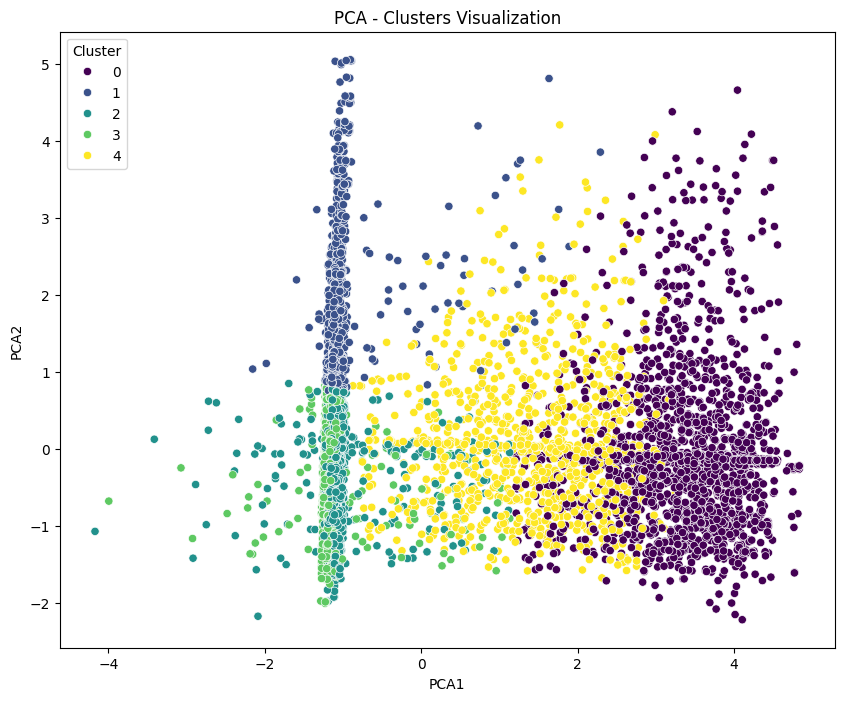

In [238]:
# Reduce dimensions with PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(processed_data)
pca_df = pd.DataFrame(data=pca_result, columns=['PCA1', 'PCA2'])
pca_df['Cluster'] = clusters

# Visualize the PCA-reduced data
plt.figure(figsize=(10, 8))
sns.scatterplot(data=pca_df, x='PCA1', y='PCA2', hue='Cluster', palette='viridis')
plt.title('PCA - Clusters Visualization')
plt.show()


### Descriptive statistics

In [230]:
cluster_descriptive_stats = data.groupby('Cluster').describe()
print(cluster_descriptive_stats)


        user score                                                     \
             count      mean       std  min     25%     50%  75%  max   
Cluster                                                                 
0           2033.0  6.868400  1.277313  0.5  6.6000  6.9606  7.6  9.7   
1           1327.0  4.647400  1.205545  0.3  4.0000  5.0000  5.5  6.0   
2           3411.0  7.441509  0.749360  5.9  6.9606  7.4000  8.0  9.8   
3           2933.0  7.432656  0.765020  5.9  6.9000  7.4000  8.0  9.6   
4           1047.0  6.867245  1.196405  1.5  6.3000  6.9606  7.7  9.1   

        total_sales            ... pal_sales         other_sales            \
              count      mean  ...       75%     max       count      mean   
Cluster                        ...                                           
0            2033.0  0.049972  ...    0.0148  0.1033      2033.0  0.002565   
1            1327.0  0.253347  ...    0.0930  0.1722      1327.0  0.011558   
2            3411.0  0.25

### Feature Distribution

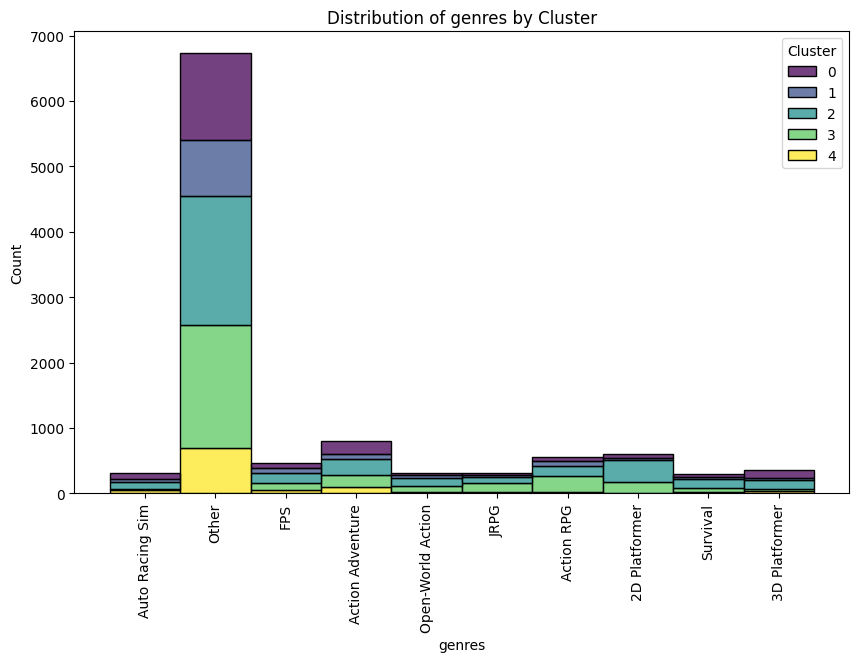

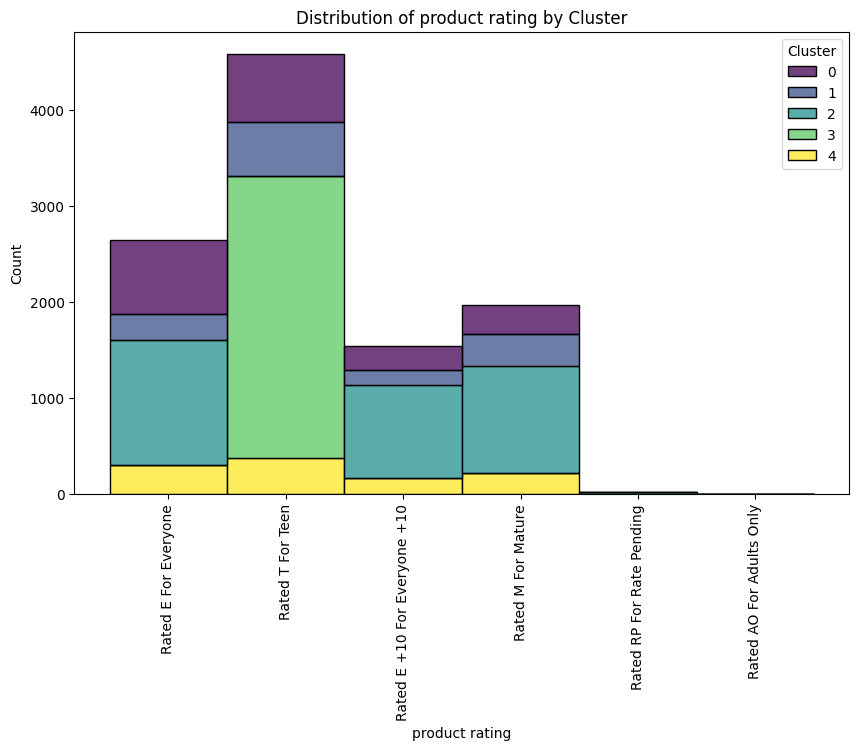

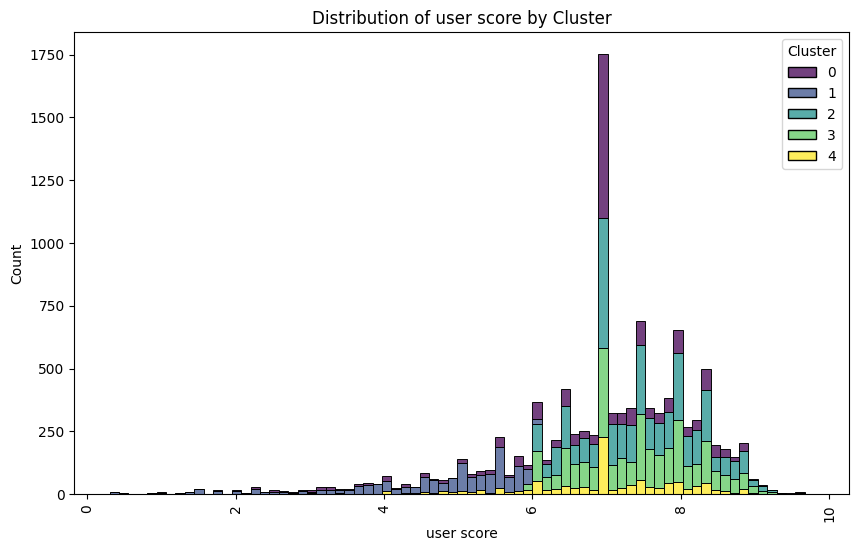

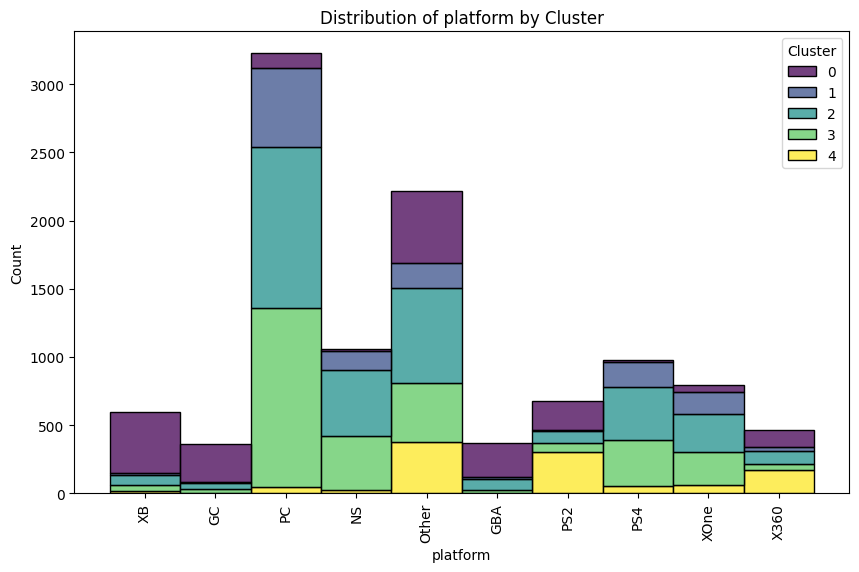

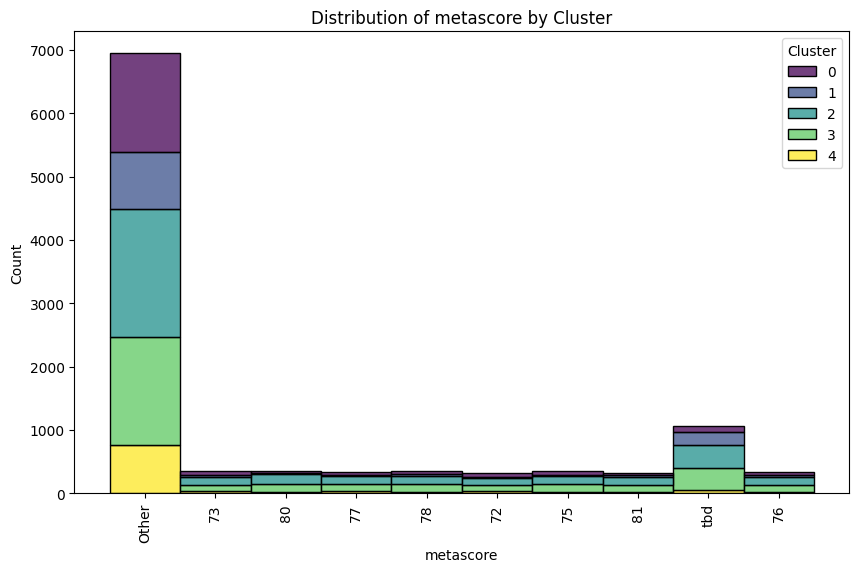

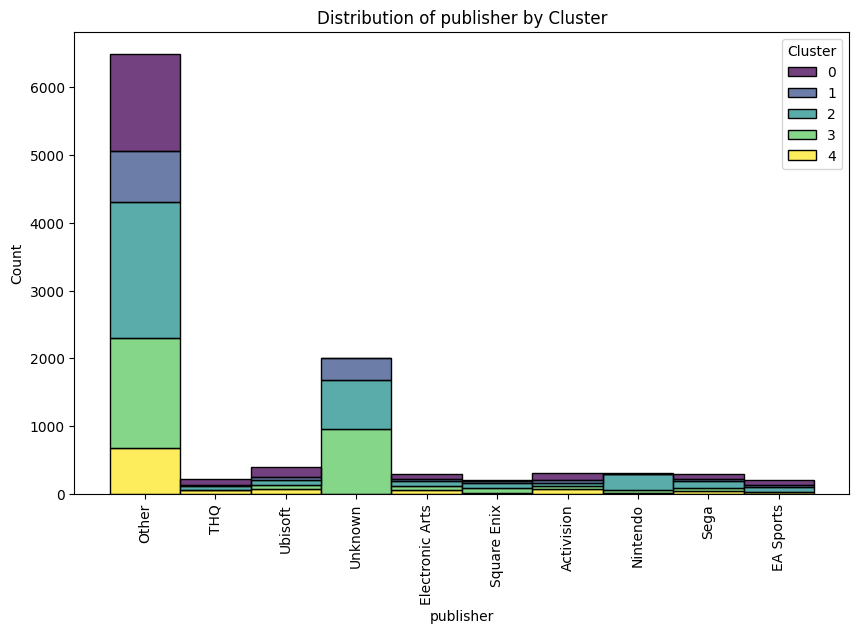

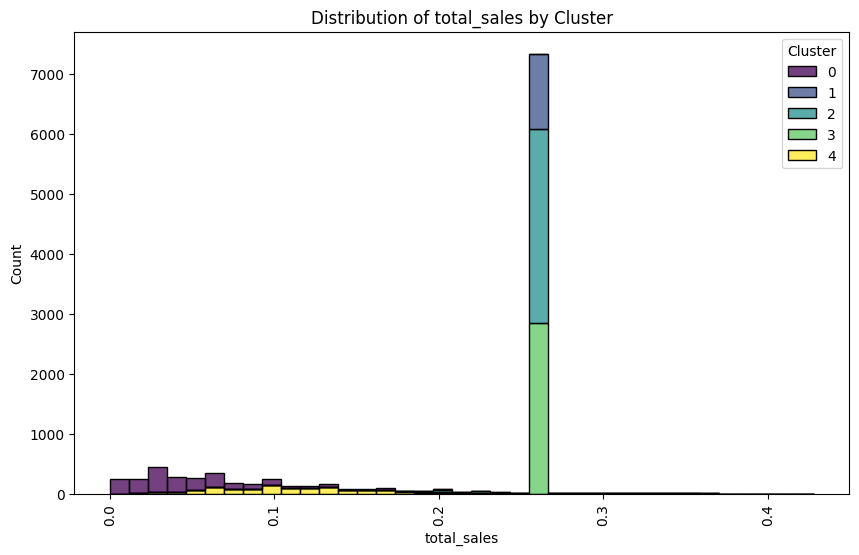

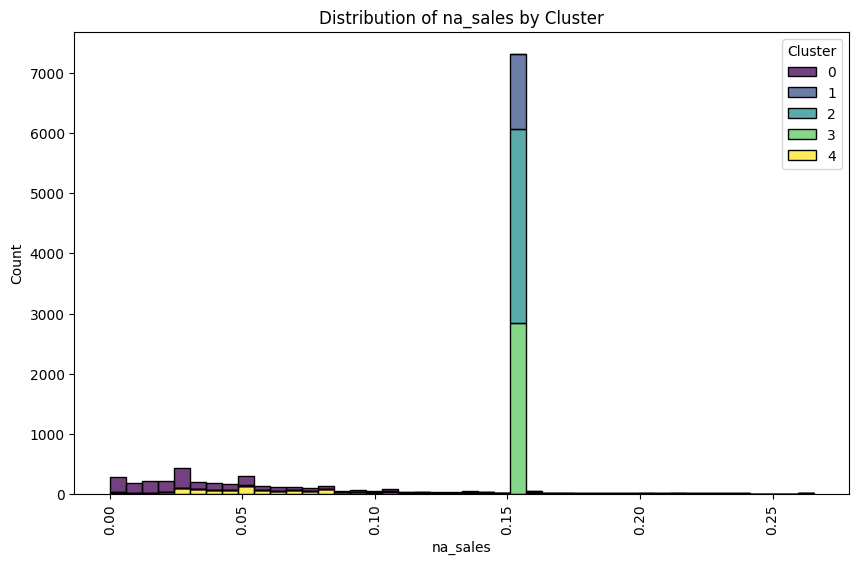

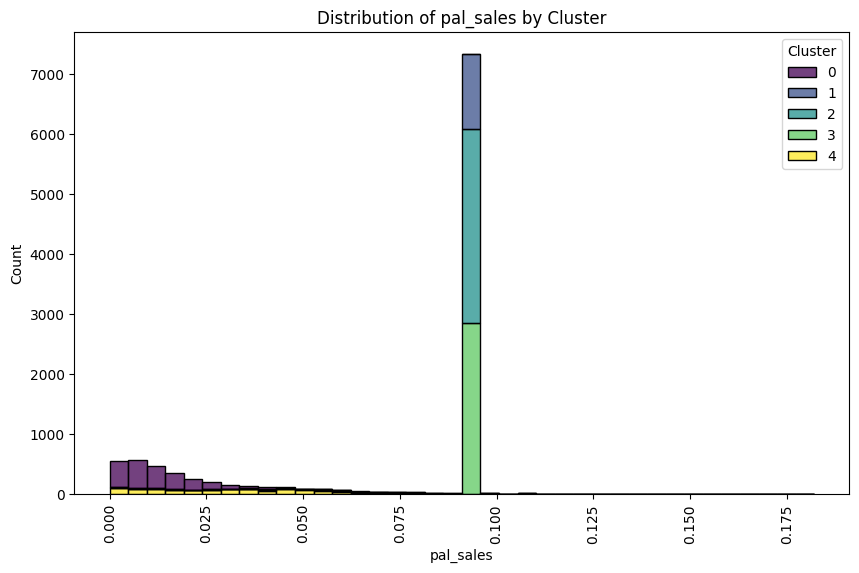

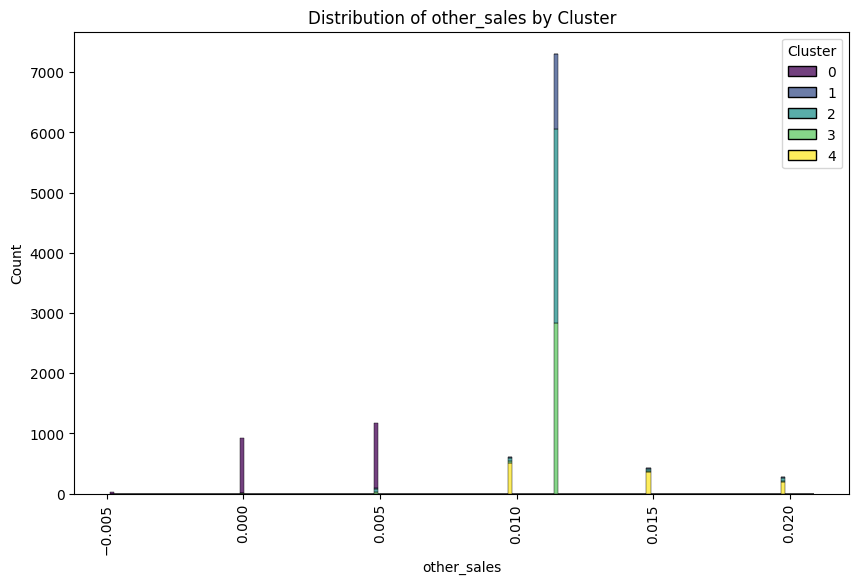

In [237]:
# Plot the distribution of each feature within each cluster
for column in data.columns:
    if column != 'Cluster':
        plt.figure(figsize=(10, 6))
        sns.histplot(data=data, x=column, hue='Cluster', multiple='stack', palette='viridis')
        plt.title(f'Distribution of {column} by Cluster')
        plt.xticks(rotation=90)  # Rotate x-axis labels
        plt.show()


### Feature-Feature plt

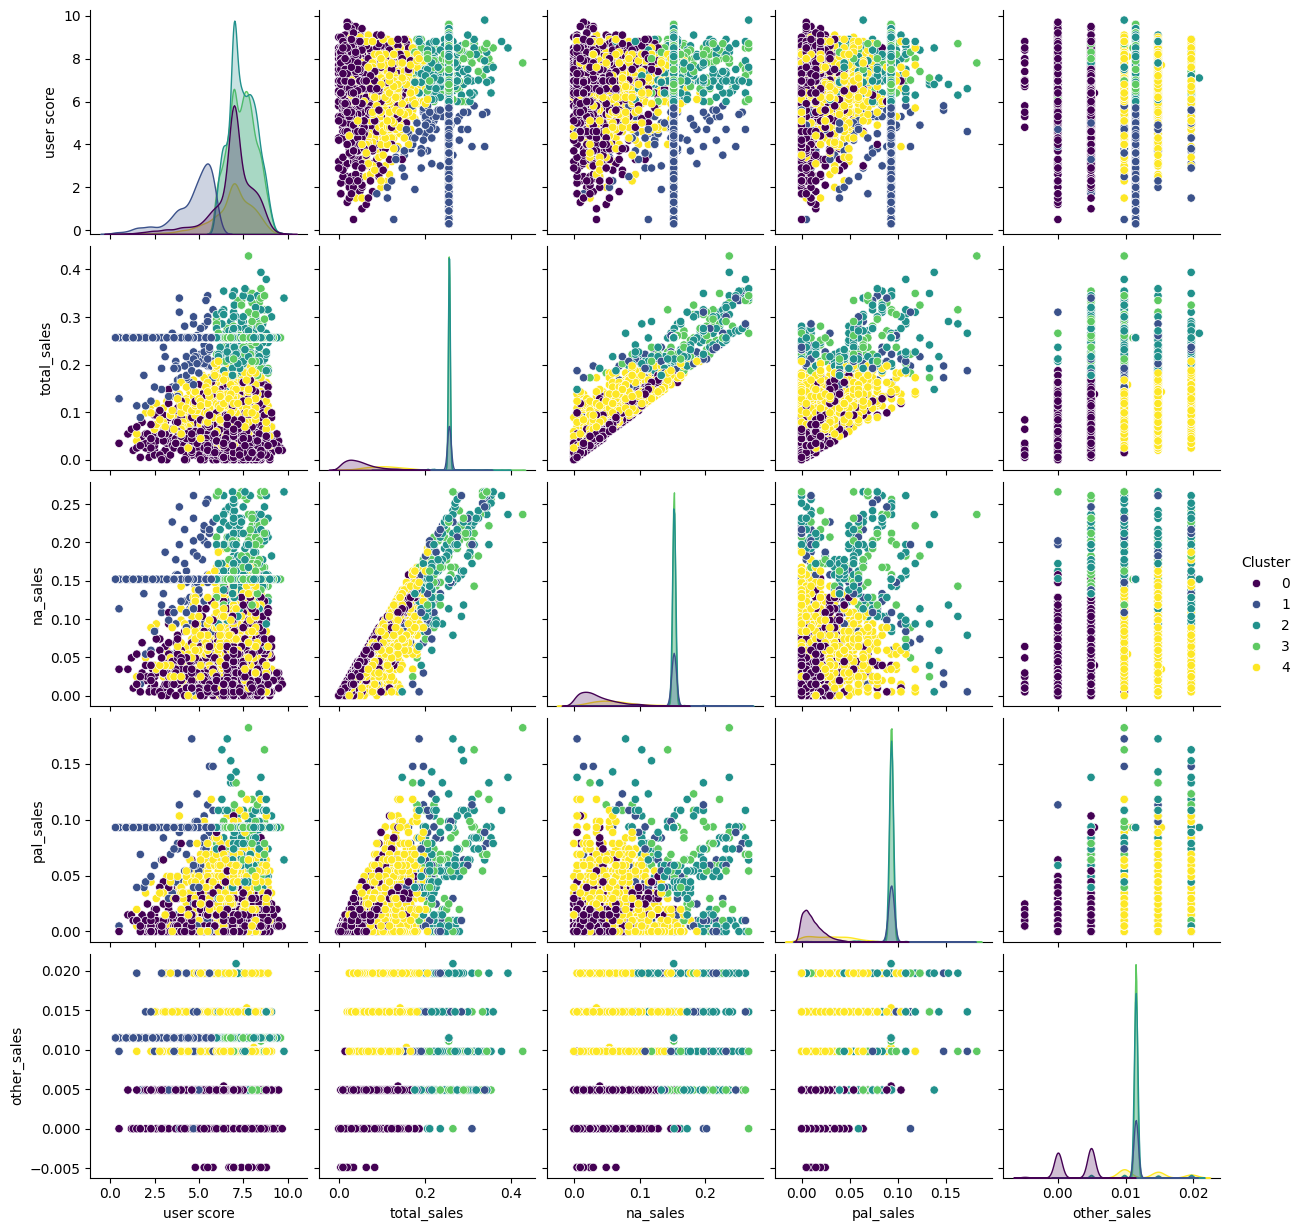

In [239]:
# Use pair plots to visualize relationships between features within each cluster
sns.pairplot(data, hue='Cluster', palette='viridis')
plt.show()


## Kmedian

In [248]:
optimal_k = 10

# Apply k-medoids clustering with the optimal number of clusters
kmedoids = KMedoids(n_clusters=optimal_k, random_state=42)
clusters = kmedoids.fit_predict(processed_data)

# Add the cluster labels to the original DataFrame
data['Cluster'] = clusters

# Display the first few rows with cluster labels
print(data.head())

/usr/local/lib/python3.10/dist-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 6 is empty! self.labels_[self.medoid_indices_[6]] may not be labeled with its corresponding cluster (6).
  warnings.warn(


            genres                product rating  user score platform  \
0  Auto Racing Sim          Rated E For Everyone      6.9606       XB   
1  Auto Racing Sim          Rated E For Everyone      6.9606       GC   
2            Other              Rated T For Teen      7.5000       PC   
3            Other  Rated E +10 For Everyone +10      6.2000       NS   
4              FPS              Rated T For Teen      6.6000       PC   

  metascore publisher  total_sales  na_sales  pal_sales  other_sales  Cluster  
0     Other     Other       0.1181    0.0886     0.0246       0.0049        9  
1     Other     Other       0.0689    0.0541     0.0148       0.0000        9  
2     Other     Other       0.2563    0.1518     0.0930       0.0115        6  
3     Other     Other       0.2563    0.1518     0.0930       0.0115        8  
4     Other     Other       0.2563    0.1518     0.0930       0.0115        4  


### TSNE visualization

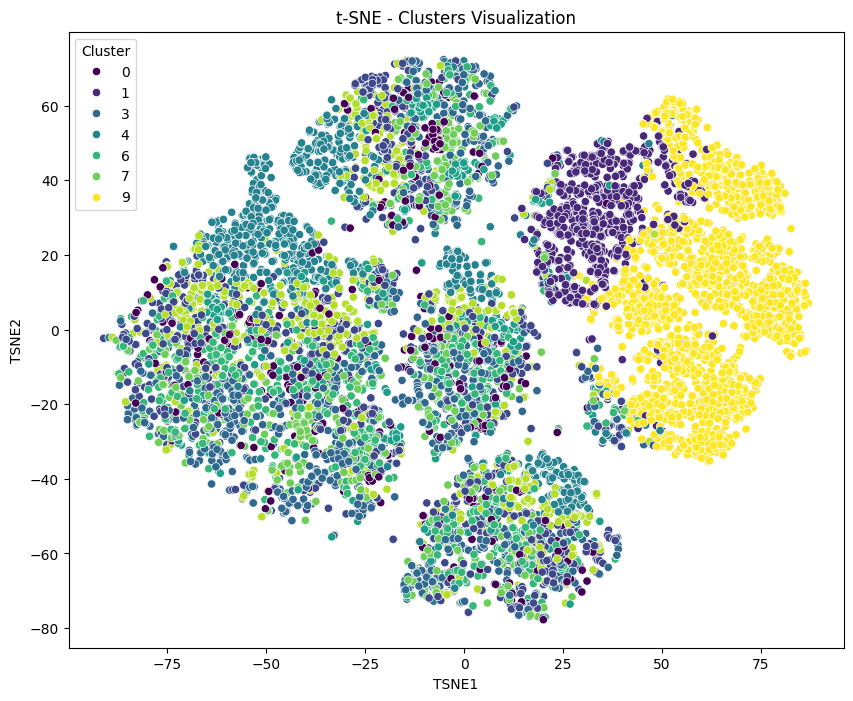

In [249]:
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(processed_data)
tsne_df = pd.DataFrame(data=tsne_result, columns=['TSNE1', 'TSNE2'])
tsne_df['Cluster'] = clusters

plt.figure(figsize=(10, 8))
sns.scatterplot(data=tsne_df, x='TSNE1', y='TSNE2', hue='Cluster', palette='viridis')
plt.title('t-SNE - Clusters Visualization')
plt.show()

### PCA visualization

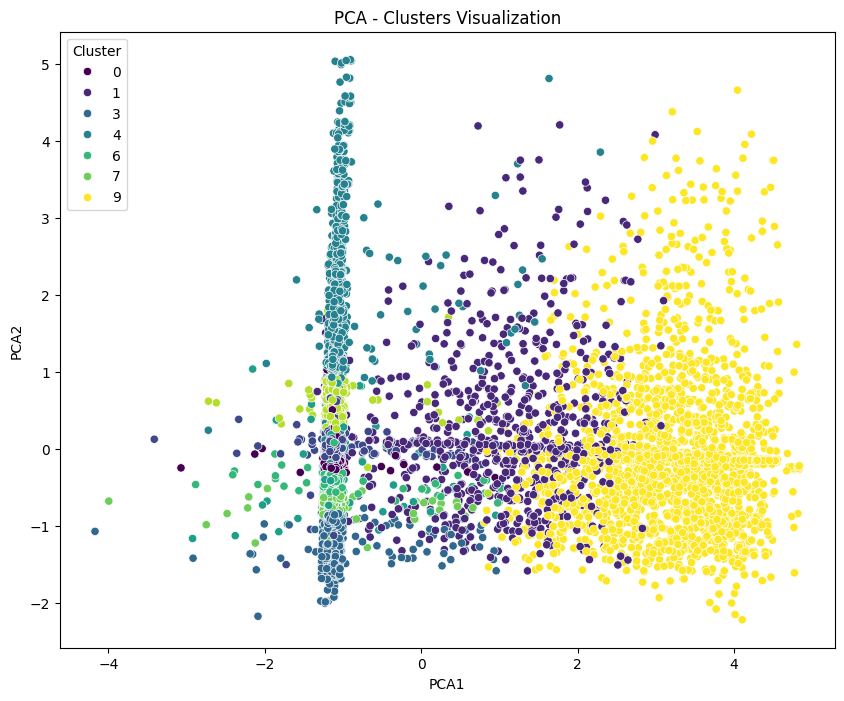

In [250]:
# Reduce dimensions with PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(processed_data)
pca_df = pd.DataFrame(data=pca_result, columns=['PCA1', 'PCA2'])
pca_df['Cluster'] = clusters

# Visualize the PCA-reduced data
plt.figure(figsize=(10, 8))
sns.scatterplot(data=pca_df, x='PCA1', y='PCA2', hue='Cluster', palette='viridis')
plt.title('PCA - Clusters Visualization')
plt.show()


### Descriptive statistics

In [251]:
cluster_descriptive_stats = data.groupby('Cluster').describe()
print(cluster_descriptive_stats)


        user score                                                  \
             count      mean       std  min  25%     50%  75%  max   
Cluster                                                              
0            598.0  7.104419  0.387333  5.4  7.2  7.2000  7.3  7.6   
1            804.0  6.695337  1.285084  1.5  6.1  6.9606  7.5  9.1   
2           1288.0  6.935545  0.325962  5.4  6.8  6.9606  7.0  8.9   
3           1311.0  8.448818  0.322438  7.8  8.2  8.4000  8.7  9.8   
4           1127.0  4.511358  1.241516  0.3  3.9  4.9000  5.4  6.8   
5            455.0  7.330669  0.828202  5.4  6.8  7.4000  7.9  9.1   
6           1136.0  7.381018  0.400037  5.5  7.4  7.5000  7.6  7.7   
7            762.0  7.961680  0.228981  7.7  7.8  7.9000  8.0  9.2   
8            979.0  6.309713  0.418383  4.6  6.0  6.3000  6.5  8.1   
9           2291.0  6.902686  1.258760  0.5  6.6  6.9606  7.7  9.7   

        total_sales            ... pal_sales         other_sales            \
           

### Feature Distribution

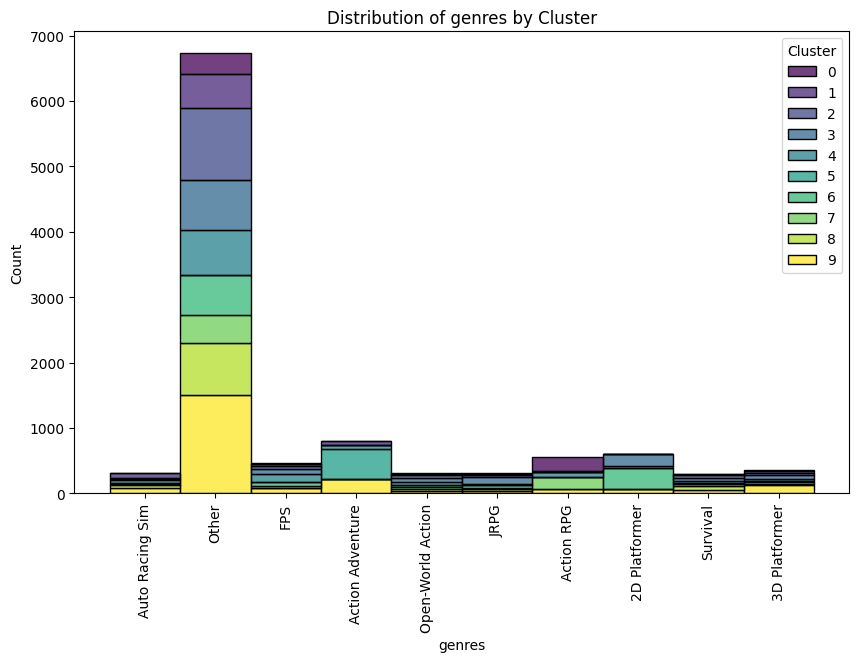

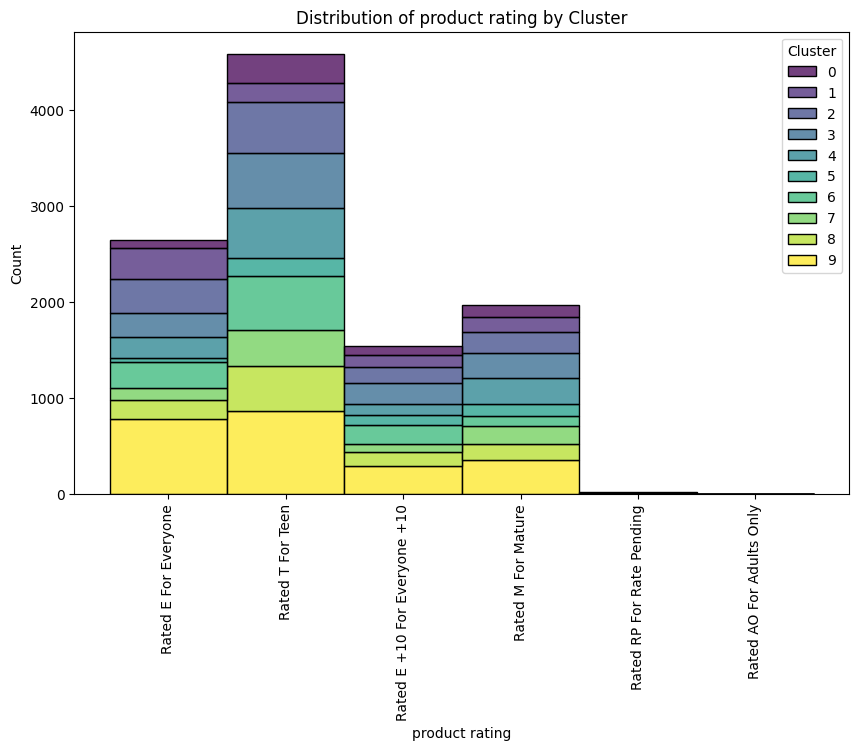

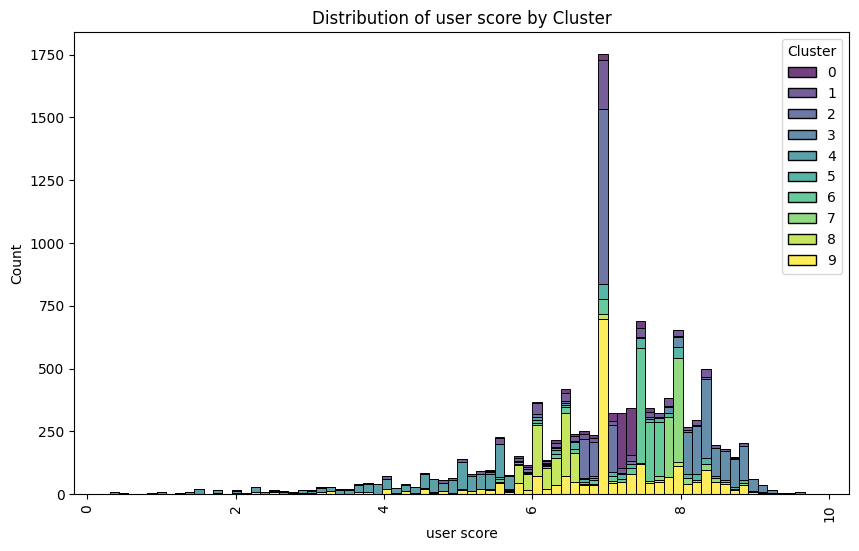

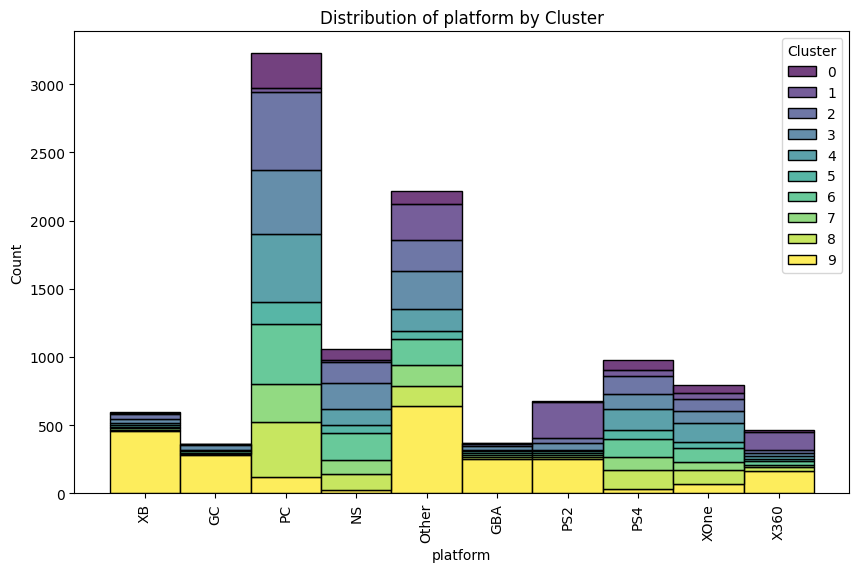

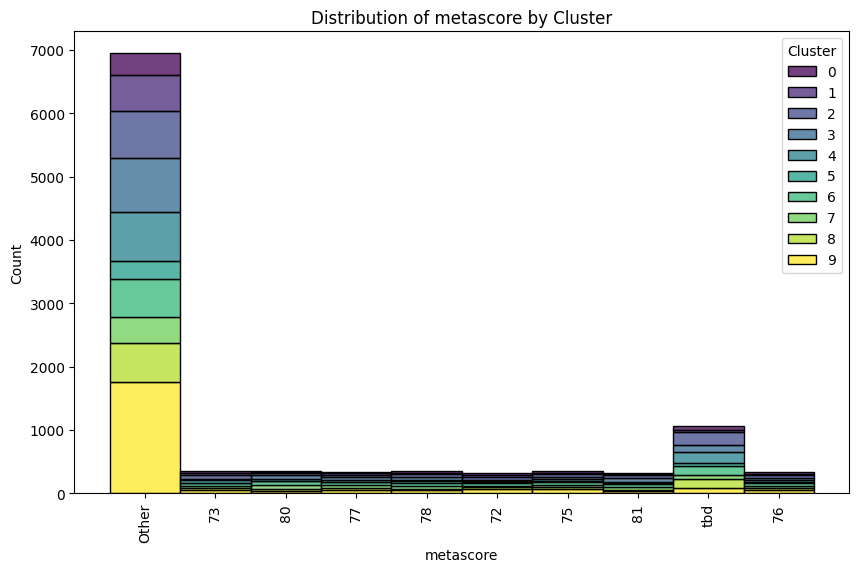

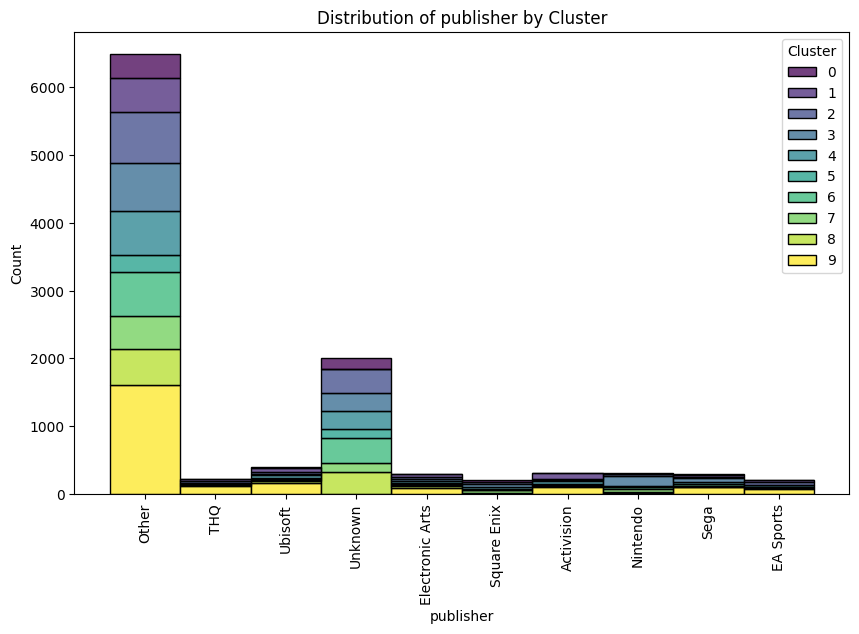

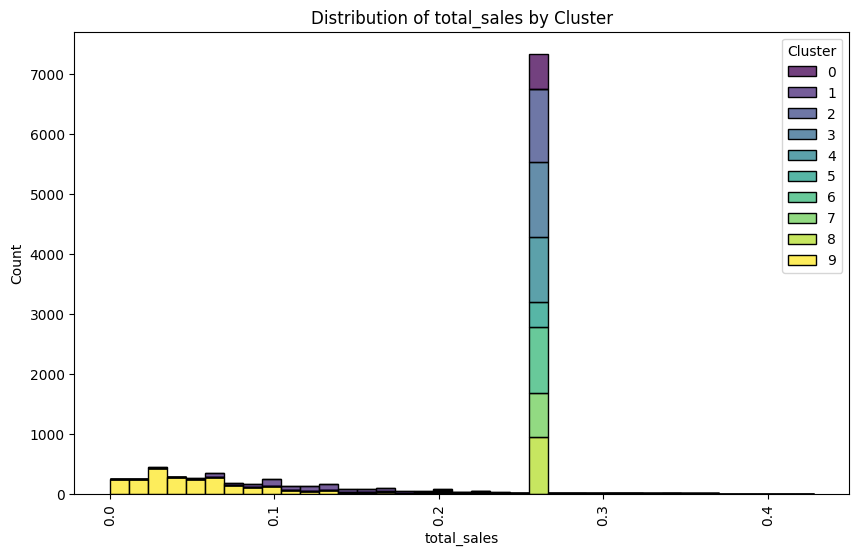

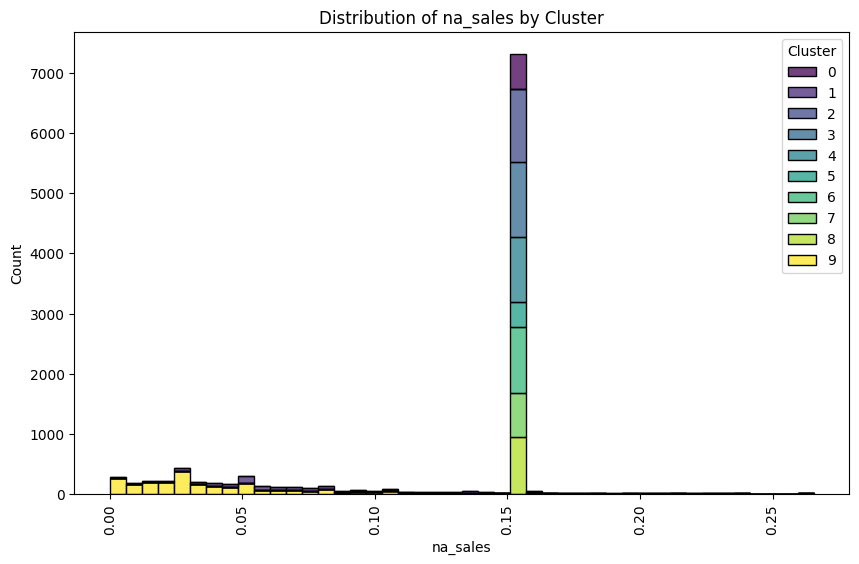

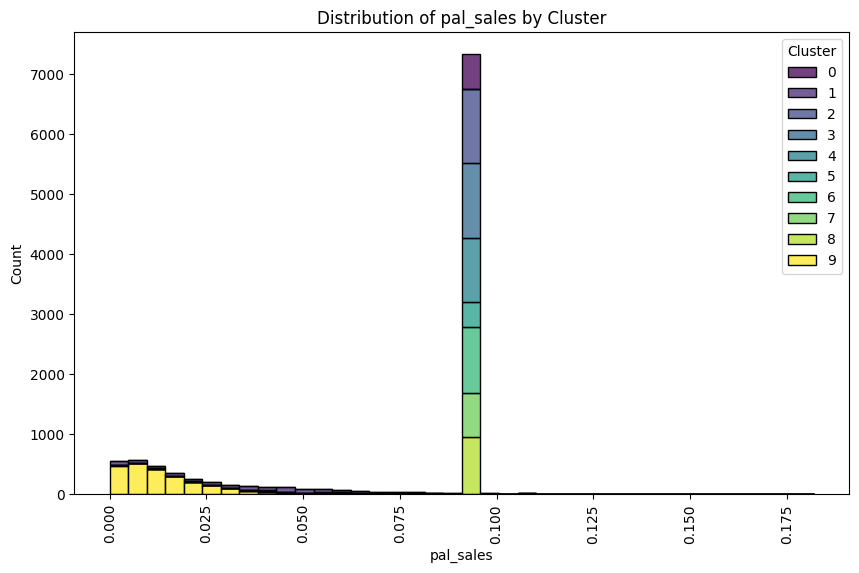

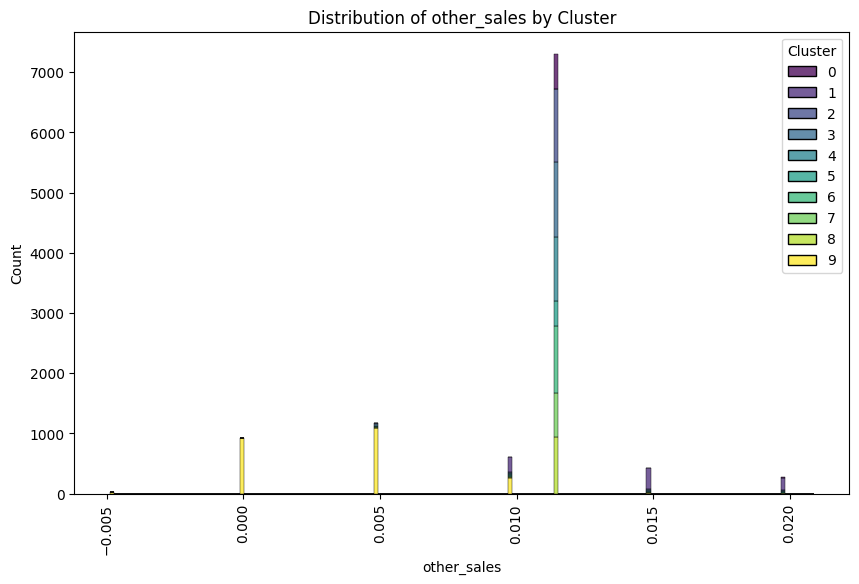

In [252]:
# Plot the distribution of each feature within each cluster
for column in data.columns:
    if column != 'Cluster':
        plt.figure(figsize=(10, 6))
        sns.histplot(data=data, x=column, hue='Cluster', multiple='stack', palette='viridis')
        plt.title(f'Distribution of {column} by Cluster')
        plt.xticks(rotation=90)  # Rotate x-axis labels
        plt.show()


### Feature-Feature plt

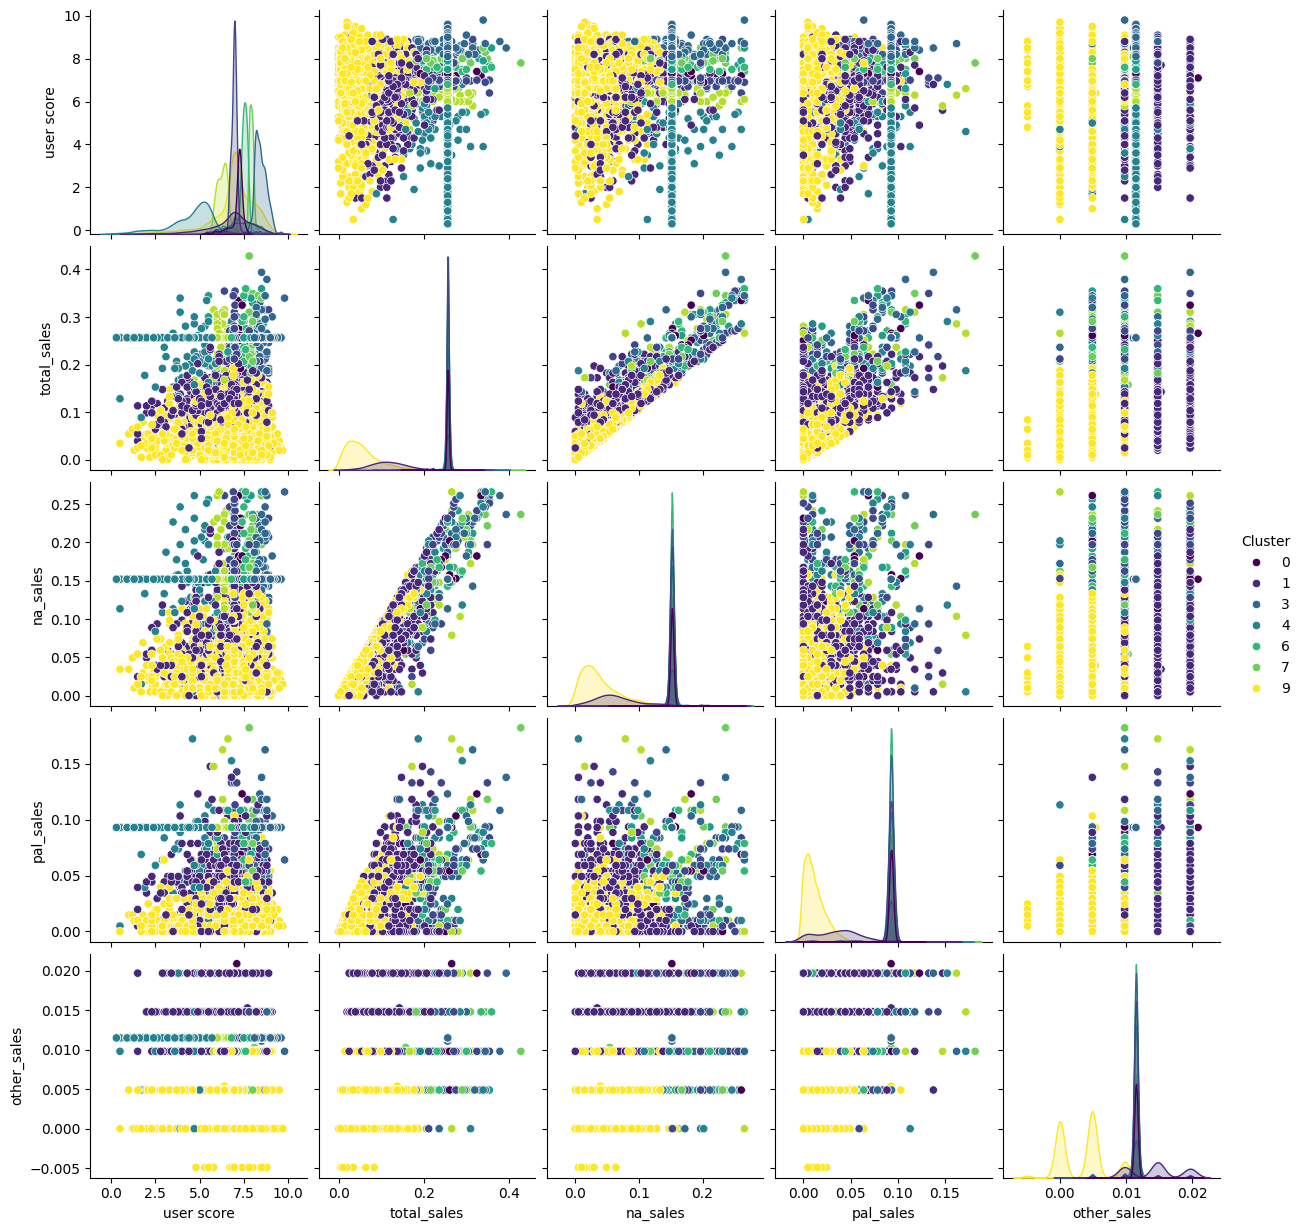

In [253]:
# Use pair plots to visualize relationships between features within each cluster
sns.pairplot(data, hue='Cluster', palette='viridis')
plt.show()


# Classification

## Load dataset

In [60]:
data = pd.read_csv(f'{project_path}/datasets/data_processed.csv')

## Drop unnecessary Cols

In [61]:
# ['title', 'genres', 'product rating', 'user score', 'user ratings count',
#        'platform', 'metascore', 'metascore_count', 'img', 'publisher',
#        'developer', 'total_sales', 'na_sales', 'pal_sales', 'other_sales',
#        'release date', 'last_update', 'total score', 'score',
#        'Processed_title', 'Stemmed_title', 'Lemmatized_title',
#        'Processed_genres', 'Stemmed_genres', 'Lemmatized_genres']

data.drop(columns=['title',
       'img',

       'release date', 'last_update', 'score',
       'Processed_title', 'Stemmed_title', 'Lemmatized_title',
       'Processed_genres', 'Stemmed_genres', 'Lemmatized_genres'], inplace=True)

## Feature Selection

In [62]:
features = ['genres', 'product rating', 'platform', 'metascore', 'total_sales', 'user ratings count', 'metascore_count', 'publisher',
       'developer', 'na_sales', 'pal_sales', 'other_sales', 'total score', ]

## Target Selection

In [63]:
target = 'user score'

## Convert Continuous to Categorical

In [64]:
bins = [0, 4, 7, 10]  # Example bin ranges
labels = ['low', 'medium', 'high']

# Create a new categorical target column
data['user_score_category'] = pd.cut(data[target], bins=bins, labels=labels)

## Categorical & Numerical Separation

In [65]:
numerical_columns = data.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_columns = data.select_dtypes(include=['object', 'category']).columns.tolist()

numerical_columns.remove('user score')
categorical_columns.remove('user_score_category')
print("Numerical columns:", numerical_columns)
print("Categorical columns:", categorical_columns)


Numerical columns: ['user ratings count', 'metascore_count', 'total_sales', 'na_sales', 'pal_sales', 'other_sales', 'total score']
Categorical columns: ['genres', 'product rating', 'platform', 'metascore', 'publisher', 'developer']


In [39]:
# Split numerical and categorical columns
numerical_columns = ['total_sales']
categorical_columns = ['genres', 'product rating', 'platform', 'metascore']

## Separate Features and Labels

In [66]:
# Ensure only relevant columns are processed
X = data[features]
y = data['user_score_category']
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Categorical & Numerical Preprocessors

In [67]:
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_columns),
        ('cat', categorical_transformer, categorical_columns)
    ])

## Train & Test models

### Radnom Forest

In [68]:
print("Model: Random Forest")
rf_clf = Pipeline(steps=[('preprocessor', preprocessor),
                         ('classifier', RandomForestClassifier(random_state=42))])
rf_clf.fit(X_train, y_train)
y_pred_rf = rf_clf.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.2f}")
print(f"Precision: {precision_score(y_test, y_pred_rf, average='weighted'):.2f}")
print(f"Recall: {recall_score(y_test, y_pred_rf, average='weighted'):.2f}")
print(f"F1 Score: {f1_score(y_test, y_pred_rf, average='weighted'):.2f}")
print("-" * 30)

Model: Random Forest
Accuracy: 0.78
Precision: 0.79
Recall: 0.78
F1 Score: 0.77
------------------------------


### Logistic Regression

In [69]:
print("Model: Logistic Regression")
lr_clf = Pipeline(steps=[('preprocessor', preprocessor),
                         ('classifier', LogisticRegression(random_state=42, max_iter=1000))])
lr_clf.fit(X_train, y_train)
y_pred_lr = lr_clf.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred_lr):.2f}")
print(f"Precision: {precision_score(y_test, y_pred_lr, average='weighted'):.2f}")
print(f"Recall: {recall_score(y_test, y_pred_lr, average='weighted'):.2f}")
print(f"F1 Score: {f1_score(y_test, y_pred_lr, average='weighted'):.2f}")
print("-" * 30)

Model: Logistic Regression
Accuracy: 0.77
Precision: 0.77
Recall: 0.77
F1 Score: 0.76
------------------------------


### SVM

In [70]:
print("Model: SVM")
svm_clf = Pipeline(steps=[('preprocessor', preprocessor),
                          ('classifier', SVC(random_state=42))])
svm_clf.fit(X_train, y_train)
y_pred_svm = svm_clf.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred_svm):.2f}")
print(f"Precision: {precision_score(y_test, y_pred_svm, average='weighted'):.2f}")
print(f"Recall: {recall_score(y_test, y_pred_svm, average='weighted'):.2f}")
print(f"F1 Score: {f1_score(y_test, y_pred_svm, average='weighted'):.2f}")
print("-" * 30)

Model: SVM
Accuracy: 0.72
Precision: 0.73
Recall: 0.72
F1 Score: 0.71
------------------------------


### Decision Tree

In [71]:
print("Model: Decision Tree")
dt_clf = Pipeline(steps=[('preprocessor', preprocessor),
                          ('classifier', DecisionTreeClassifier(random_state=42))])
dt_clf.fit(X_train, y_train)
y_pred_dt = dt_clf.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred_dt):.2f}")
print(f"Precision: {precision_score(y_test, y_pred_dt, average='weighted'):.2f}")
print(f"Recall: {recall_score(y_test, y_pred_dt, average='weighted'):.2f}")
print(f"F1 Score: {f1_score(y_test, y_pred_dt, average='weighted'):.2f}")
print("-" * 30)

Model: Decision Tree
Accuracy: 0.94
Precision: 0.94
Recall: 0.94
F1 Score: 0.94
------------------------------
